In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 2
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 2
DIS_N_CLASSES = 1
EPOCH = 100

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet34"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "sigmoid"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 3e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-3
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.canny2 import Canny

In [11]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [12]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [13]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [14]:
perceptual_ext = PerceptualLoss()

In [15]:
def train_a2b_epoch(generator, gen_optimizer, discriminator, dis_optimizer, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    discriminator = discriminator.train().to(device)
    
    dis_l = 0
    gen_l = 0
    ssim_l = 0
    mae_l = 0
    air_l = 0
    bone_l = 0
    edge_l = 0
    perceptual_l = 0
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)
        *_, edge_x = Canny(low_threshold=0, high_threshold=0.2).to(device)(x)
        
        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

       ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        set_requires_grad(discriminator, True)
        dis_optimizer.zero_grad()
        
        *_, edge_y_pr = Canny(low_threshold=0, high_threshold=0.2).to(device)(y_pr.detach())
        *_, edge_y = Canny(low_threshold=0, high_threshold=0.2).to(device)(y)
        
        y_cls = discriminator(torch.cat((y, edge_y), dim=1))
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(torch.cat((y_pr.detach(), edge_y_pr), dim=1))
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        _dis = nn.BCELoss()(y_cls.float(), torch.zeros(y_cls.size(), dtype=torch.float, device=device)) + \
                                nn.BCELoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size(), dtype=torch.float, device=device))

        _dis.backward()
        dis_optimizer.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        set_requires_grad(discriminator, False)
        gen_optimizer.zero_grad()
        
        # main loss
        # Perceptual loss
        perceptual_loss = perceptual_ext(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())
        _ssim =SSIMLoss()(y_pr.float(), y.float(), data_range=1.0, size_average=True) # return (N,)
        
        # adversarial loss
        *_, edge_y_pr = Canny(low_threshold=0, high_threshold=0.2).to(device)(y_pr)
        assert y_pr.requires_grad, "ct_pred without gradient"
        assert edge_y_pr.requires_grad, "edge without gradient"
        
        y_pr_cls = discriminator(torch.cat((y_pr, edge_y_pr), dim=1))
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        _gen = nn.BCELoss()(y_pr_cls.float(), torch.zeros(y_pr_cls.size(), dtype=torch.float, device=device))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())
        
        edge_loss = nn.BCELoss()(edge_y_pr, edge_x)
        
        _loss = _gen + air_loss + bone_loss + perceptual_loss + _mae + _ssim + edge_loss
        _loss.backward()    
        gen_optimizer.step()

        dis_l += _dis.item()
        gen_l += _gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        mae_l += _mae.item()
        ssim_l += _ssim.item()
        edge_l += edge_loss.item()
        perceptual_l += perceptual_loss.item()
        
    return  edge_l/(index+1), perceptual_l/(index+1), ssim_l/(index+1), mae_l/(index+1), air_l/(index+1), bone_l/(index+1), gen_l/(index+1), dis_l/(index+1)

In [16]:
@torch.no_grad()
def eval_epoch(generator, discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    discriminator = discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    air_ = []
    bone_ = []
    acc_ = []
    cont_ = []
    edge_ = []
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)
        *_, edge_x = Canny(low_threshold=0, high_threshold=0.2).to(device)(x)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

        *_, edge_y_pr = Canny(low_threshold=0, high_threshold=0.2).to(device)(y_pr)
        *_, edge_y = Canny(low_threshold=0, high_threshold=0.2).to(device)(y)
        
        y_cls = discriminator(torch.cat((y, edge_y), dim=1))
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(torch.cat((y_pr, edge_y_pr), dim=1))
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]
        
        edge = Fscore()(edge_y_pr, edge_x)
        edge_ += [edge.item()]
        
        # adversarial
        acc = Accuracy()(y_cls, torch.zeros(y_cls.size(), device=y_cls.device))
        acc_ += [acc.item()]
        acc = Accuracy()(y_pr_cls, torch.ones(y_pr_cls.size(), device=y_pr_cls.device))
        acc_ += [acc.item()]
        
        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(edge_)/len(edge_), sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(acc_)/len(acc_)

In [17]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        *_, edge_x = Canny(low_threshold=0, high_threshold=0.2).to(device)(x)
        *_, edge_y = Canny(low_threshold=0, high_threshold=0.2).to(device)(y)
        *_, edge_y_pr = Canny(low_threshold=0, high_threshold=0.2).to(device)(y_pr)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _edge = Fscore()(edge_y_pr, edge_x)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            print("edge dice score = {}".format(_edge.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [18]:
from codes.activation import Activation
import torchvision.models as models

In [19]:
class Model(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Model, self).__init__()
        
        encoder = models.resnet34()
        encoder.conv1 = nn.Conv2d(in_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        encoder.fc = nn.Linear(in_features=512, out_features=n_classes)
        self.encoder = encoder
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        x = self.encoder(x)
        return self.activation(x)

# Read Data

In [20]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [21]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [22]:
trainset = Dataset(train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [23]:
len(trainset), len(testset)

(1344, 191)

In [24]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f9b667101c0>,)

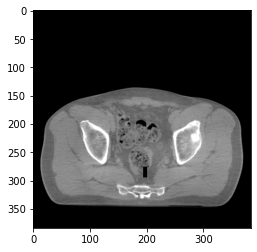

In [25]:
plt.imshow(x.squeeze(), 'gray'),

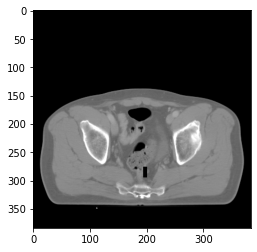

In [26]:
plt.imshow(y.squeeze(), 'gray')

In [27]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [28]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [29]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [30]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)

In [31]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [32]:
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
replace_relu_to_leakyReLU(discriminator)

In [33]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): LeakyReLU(negative_slope=0.01)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): InstanceNorm2d(64, e

In [34]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
dis_optimizer = Optimizer(discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

In [35]:
wandb.watch(model)
wandb.watch(discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_edge, loss_perceptual, loss_ssim, loss_mae, loss_air, loss_bone, loss_gen, loss_dis = train_a2b_epoch(model, gen_optimizer, discriminator, dis_optimizer, trainloader, device)
        score_edge_train, score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_air_train, score_bone_train, score_cont_train, score_acc_train = eval_epoch(model, discriminator, trainloader, device)
        score_edge_test, score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_air_test, score_bone_test, score_cont_test, score_acc_test = eval_epoch(model, discriminator, testloader, device)

        wandb.log({
            "loss ssim": loss_ssim,
            "loss mae": loss_mae,
            "loss perceptual": loss_perceptual,
            "loss mask": loss_air,
            "loss gen": loss_gen,
            "loss dis": loss_dis,
            "loss bone": loss_bone,
            "loss edge": loss_edge,
            "trainset edge scroe": score_edge_train,
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_acc_train,
            "testset edge score": score_edge_test,
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_acc_test
        })
        
        
        if score_bone_test +  score_air_test + score_cont_test >  max_score:
            max_score = score_bone_test +  score_air_test + score_cont_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "dicriminator": discriminator.state_dict(),
                "dis_optim": dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

672it [05:18,  2.11it/s]
672it [01:18,  8.51it/s]
96it [00:10,  9.10it/s]
672it [03:30,  3.19it/s]
672it [01:08,  9.79it/s]
96it [00:09,  9.94it/s]
672it [03:16,  3.41it/s]
672it [01:11,  9.45it/s]
96it [00:10,  9.47it/s]
672it [03:17,  3.41it/s]
672it [01:06, 10.09it/s]
96it [00:09,  9.71it/s]
672it [03:15,  3.44it/s]
672it [01:07,  9.90it/s]
96it [00:10,  9.56it/s]
672it [03:18,  3.38it/s]
672it [01:07,  9.90it/s]
96it [00:09,  9.75it/s]
672it [03:14,  3.45it/s]
672it [01:06, 10.07it/s]
96it [00:09,  9.86it/s]
672it [03:16,  3.41it/s]
672it [01:11,  9.44it/s]
96it [00:10,  9.19it/s]
672it [03:19,  3.36it/s]
672it [01:08,  9.84it/s]
96it [00:10,  9.38it/s]
672it [03:23,  3.31it/s]
672it [01:11,  9.36it/s]
96it [00:09,  9.90it/s]
672it [03:17,  3.41it/s]
672it [01:08,  9.88it/s]
96it [00:09, 10.01it/s]
672it [03:11,  3.51it/s]
672it [01:07, 10.00it/s]
96it [00:09,  9.96it/s]
672it [03:10,  3.53it/s]
672it [01:07,  9.92it/s]
96it [00:09,  9.82it/s]
672it [03:13,  3.47it/s]
672it [01:07,

In [36]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [37]:
model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [38]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.9010857343673706
psnr score = 26.418106079101562
snr score = 16.48104476928711
mae error = 0.015792930498719215
air dice score = 0.9979309937141639
bone dice score = 0.9699457557547289
contour dice score = 0.39880597591400146
edge dice score = 0.44387009739875793


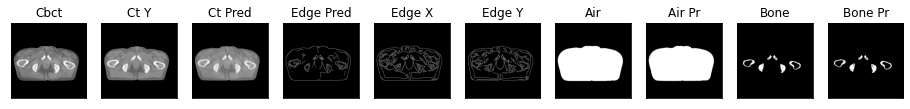

1it [00:00,  1.97it/s]

ssim score = 0.9021084904670715
psnr score = 26.34389877319336
snr score = 16.454370498657227
mae error = 0.016078511252999306
air dice score = 0.9976955802410801
bone dice score = 0.9649611493920985
contour dice score = 0.4485645890235901
edge dice score = 0.44499215483665466


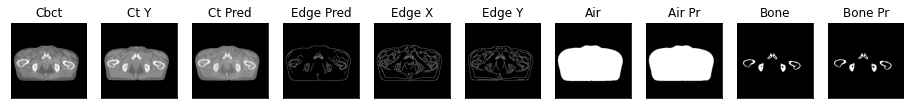

2it [00:01,  1.87it/s]

ssim score = 0.8998834490776062
psnr score = 26.075271606445312
snr score = 16.34864044189453
mae error = 0.01734813302755356
air dice score = 0.9974384741187391
bone dice score = 0.9493512974058215
contour dice score = 0.4655894637107849
edge dice score = 0.43248218297958374


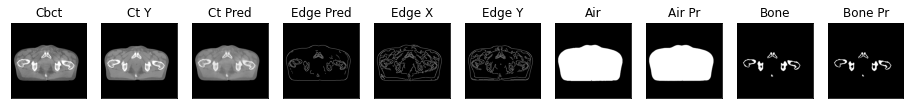

3it [00:01,  2.05it/s]

ssim score = 0.8974603414535522
psnr score = 25.995384216308594
snr score = 16.35800552368164
mae error = 0.01807023212313652
air dice score = 0.9982430164840606
bone dice score = 0.9212372082336294
contour dice score = 0.5458908081054688
edge dice score = 0.4726298749446869


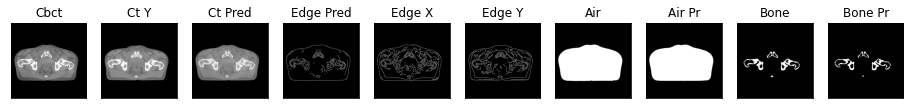

4it [00:01,  2.17it/s]

ssim score = 0.8961319327354431
psnr score = 26.024169921875
snr score = 16.427091598510742
mae error = 0.018360614776611328
air dice score = 0.9985842004692944
bone dice score = 0.8869658119670196
contour dice score = 0.5798319578170776
edge dice score = 0.4510166347026825


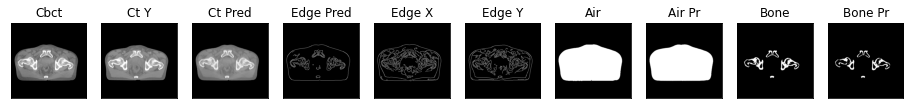

5it [00:02,  2.24it/s]

ssim score = 0.891156792640686
psnr score = 25.67922592163086
snr score = 16.21868324279785
mae error = 0.02004702016711235
air dice score = 0.9988369203240729
bone dice score = 0.8479970048685137
contour dice score = 0.5943339467048645
edge dice score = 0.47529226541519165


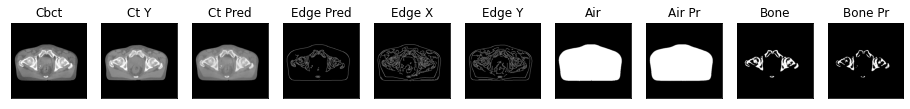

6it [00:02,  2.33it/s]

ssim score = 0.8890329599380493
psnr score = 25.529197692871094
snr score = 16.044599533081055
mae error = 0.020176954567432404
air dice score = 0.9987296824206064
bone dice score = 0.8500403840989855
contour dice score = 0.5916515588760376
edge dice score = 0.473535418510437


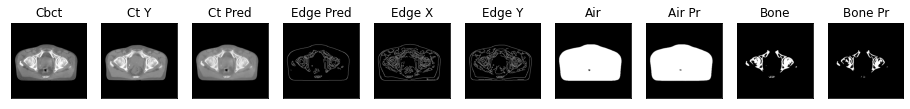

7it [00:03,  2.39it/s]

ssim score = 0.8914709687232971
psnr score = 26.225927352905273
snr score = 16.5557918548584
mae error = 0.018219446763396263
air dice score = 0.998320105420931
bone dice score = 0.9059635195170025
contour dice score = 0.5485436916351318
edge dice score = 0.4388194680213928


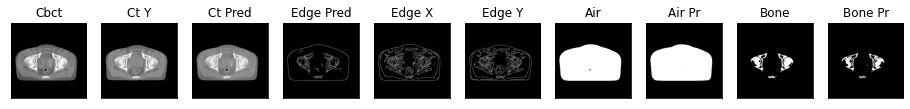

8it [00:03,  2.45it/s]

ssim score = 0.8949448466300964
psnr score = 26.699626922607422
snr score = 16.9349365234375
mae error = 0.017097750678658485
air dice score = 0.9986541866936518
bone dice score = 0.9411178639041435
contour dice score = 0.4899451434612274
edge dice score = 0.43128734827041626


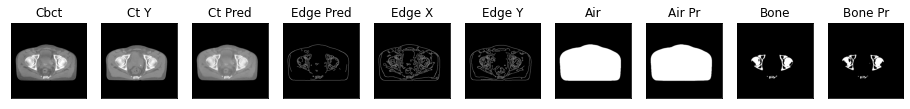

9it [00:03,  2.47it/s]

ssim score = 0.8988652229309082
psnr score = 26.730998992919922
snr score = 16.951026916503906
mae error = 0.016923466697335243
air dice score = 0.9977283608544646
bone dice score = 0.934669171363654
contour dice score = 0.4175824224948883
edge dice score = 0.43623173236846924


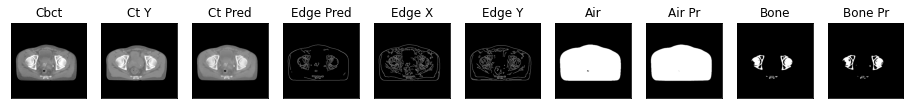

10it [00:04,  2.49it/s]

ssim score = 0.9044050574302673
psnr score = 27.048837661743164
snr score = 17.30113410949707
mae error = 0.016644790768623352
air dice score = 0.9979198901538073
bone dice score = 0.9582561307906458
contour dice score = 0.41590213775634766
edge dice score = 0.44775351881980896


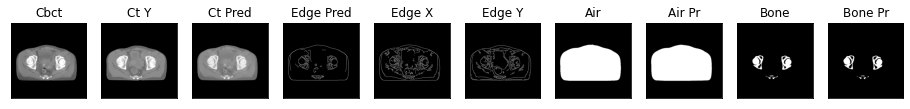

11it [00:04,  2.17it/s]

ssim score = 0.9035013914108276
psnr score = 25.901988983154297
snr score = 16.177995681762695
mae error = 0.018036838620901108
air dice score = 0.9979386569158599
bone dice score = 0.9532587228444892
contour dice score = 0.41641151905059814
edge dice score = 0.4267432689666748


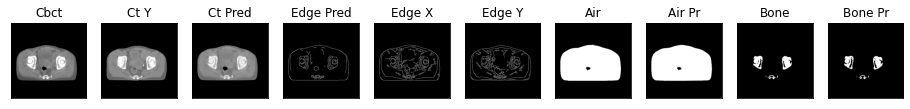

12it [00:05,  2.26it/s]

ssim score = 0.9067235589027405
psnr score = 25.116451263427734
snr score = 15.3605375289917
mae error = 0.018702657893300056
air dice score = 0.9976321689751297
bone dice score = 0.9588304093572066
contour dice score = 0.43312883377075195
edge dice score = 0.412306010723114


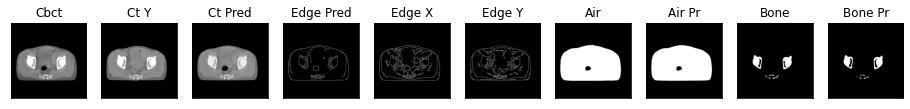

13it [00:05,  2.35it/s]

ssim score = 0.904391884803772
psnr score = 25.099048614501953
snr score = 15.201175689697266
mae error = 0.01750805974006653
air dice score = 0.9970186493001257
bone dice score = 0.9457048177422164
contour dice score = 0.4561186730861664
edge dice score = 0.4343969523906708


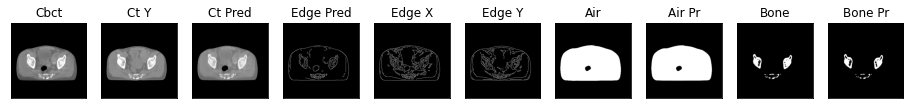

14it [00:06,  2.42it/s]

ssim score = 0.9007855653762817
psnr score = 24.99739646911621
snr score = 15.013861656188965
mae error = 0.017522308975458145
air dice score = 0.9975456602811361
bone dice score = 0.9435440302546793
contour dice score = 0.46077826619148254
edge dice score = 0.43904784321784973


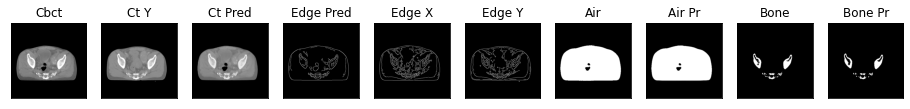

15it [00:06,  2.47it/s]

ssim score = 0.8929235935211182
psnr score = 24.71330451965332
snr score = 14.753254890441895
mae error = 0.018787384033203125
air dice score = 0.998055804811351
bone dice score = 0.9385999217841403
contour dice score = 0.4877742826938629
edge dice score = 0.4444444477558136


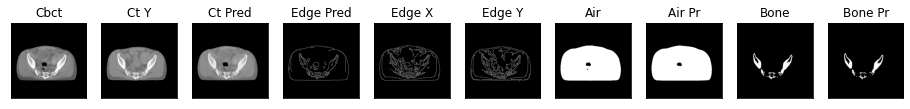

16it [00:06,  2.50it/s]

ssim score = 0.888677179813385
psnr score = 23.725704193115234
snr score = 13.763113975524902
mae error = 0.02077295444905758
air dice score = 0.9981734271478463
bone dice score = 0.9336469423132749
contour dice score = 0.44808053970336914
edge dice score = 0.4751847982406616


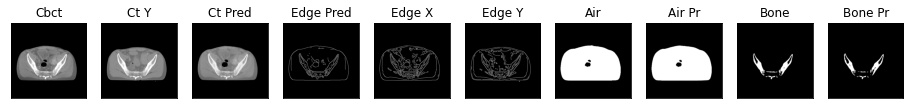

17it [00:07,  2.51it/s]

ssim score = 0.8800110220909119
psnr score = 23.116737365722656
snr score = 13.052382469177246
mae error = 0.021782590076327324
air dice score = 0.9972919851495989
bone dice score = 0.9157360406102064
contour dice score = 0.4186335504055023
edge dice score = 0.5017414093017578


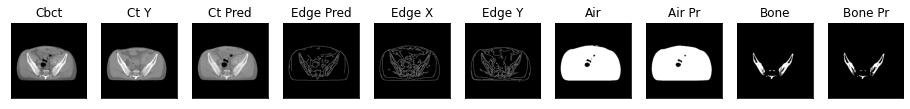

18it [00:07,  2.53it/s]

ssim score = 0.8772339820861816
psnr score = 22.8623104095459
snr score = 12.747274398803711
mae error = 0.02233862318098545
air dice score = 0.9960547282817781
bone dice score = 0.9102740583167279
contour dice score = 0.4406130313873291
edge dice score = 0.5297461748123169


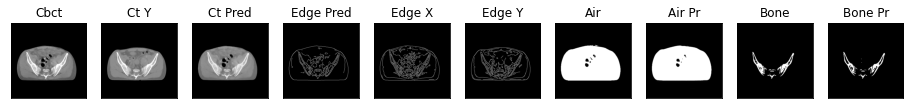

19it [00:07,  2.55it/s]

ssim score = 0.880990207195282
psnr score = 22.937698364257812
snr score = 12.810354232788086
mae error = 0.0224395003169775
air dice score = 0.99653841474879
bone dice score = 0.9110617735417127
contour dice score = 0.4111675024032593
edge dice score = 0.5151515007019043


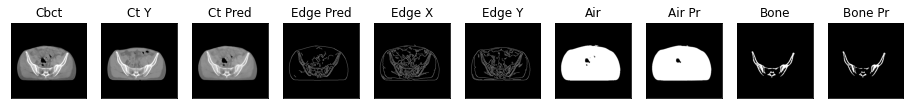

20it [00:08,  2.55it/s]

ssim score = 0.8772399425506592
psnr score = 22.752708435058594
snr score = 12.560518264770508
mae error = 0.022624755278229713
air dice score = 0.9971525242035475
bone dice score = 0.9019496228845603
contour dice score = 0.45012786984443665
edge dice score = 0.5208964347839355


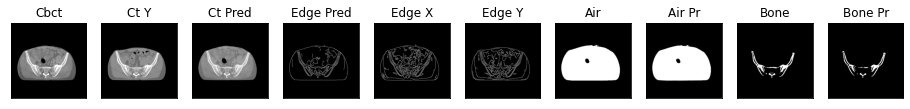

21it [00:08,  2.21it/s]

ssim score = 0.8753657341003418
psnr score = 22.868555068969727
snr score = 12.616933822631836
mae error = 0.021853381767868996
air dice score = 0.9953702663220638
bone dice score = 0.9201216141525688
contour dice score = 0.47564101219177246
edge dice score = 0.5554229021072388


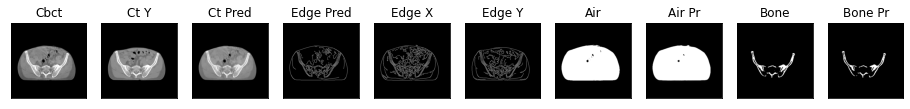

22it [00:09,  2.30it/s]

ssim score = 0.8811264634132385
psnr score = 22.9831485748291
snr score = 12.698098182678223
mae error = 0.021760165691375732
air dice score = 0.9963867742302053
bone dice score = 0.9122531711793873
contour dice score = 0.5341130495071411
edge dice score = 0.5388393402099609


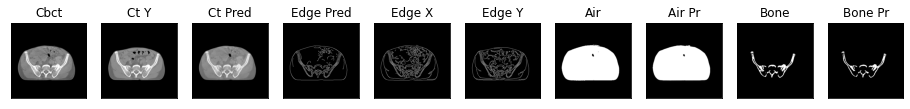

23it [00:09,  2.39it/s]

ssim score = 0.8801906704902649
psnr score = 22.948102951049805
snr score = 12.61448860168457
mae error = 0.022083910182118416
air dice score = 0.9972140375818337
bone dice score = 0.9028396791047646
contour dice score = 0.495364248752594
edge dice score = 0.5595718622207642


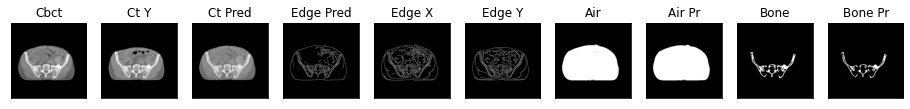

24it [00:10,  2.46it/s]

ssim score = 0.8776965141296387
psnr score = 22.781383514404297
snr score = 12.350769996643066
mae error = 0.02237299457192421
air dice score = 0.9967419129625358
bone dice score = 0.9022537971594531
contour dice score = 0.42684563994407654
edge dice score = 0.573452353477478


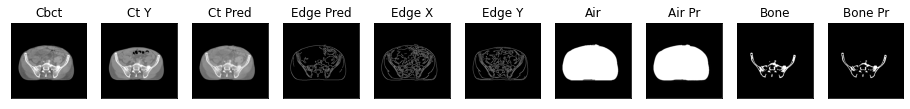

25it [00:10,  2.50it/s]

ssim score = 0.87975013256073
psnr score = 22.891803741455078
snr score = 12.378456115722656
mae error = 0.021937157958745956
air dice score = 0.9968010845393719
bone dice score = 0.8915839764805638
contour dice score = 0.5281738042831421
edge dice score = 0.563488245010376


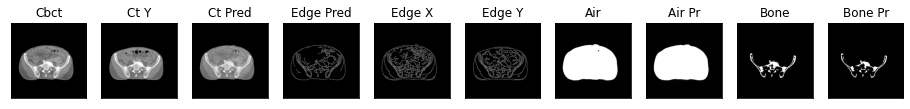

26it [00:10,  2.55it/s]

ssim score = 0.8772183656692505
psnr score = 22.982421875
snr score = 12.377885818481445
mae error = 0.022012094035744667
air dice score = 0.996383582922749
bone dice score = 0.8889960226601301
contour dice score = 0.6087560653686523
edge dice score = 0.5706883668899536


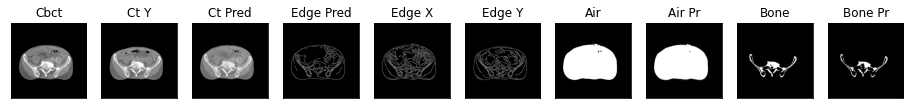

27it [00:11,  2.57it/s]

ssim score = 0.8784772753715515
psnr score = 22.96023178100586
snr score = 12.314590454101562
mae error = 0.021710556000471115
air dice score = 0.9968766139544073
bone dice score = 0.9030426884661324
contour dice score = 0.6470588445663452
edge dice score = 0.5791178941726685


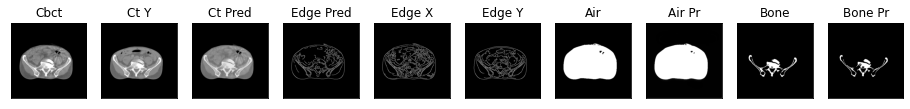

28it [00:11,  2.58it/s]

ssim score = 0.8731140494346619
psnr score = 23.80004119873047
snr score = 15.172197341918945
mae error = 0.022101543843746185
air dice score = 0.9975467325814938
bone dice score = 0.9498489425997024
contour dice score = 0.5293617248535156
edge dice score = 0.4117887020111084


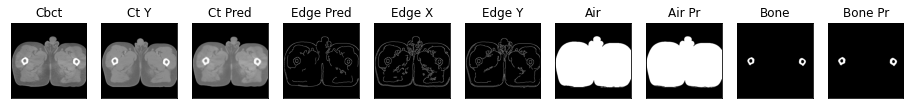

29it [00:12,  2.56it/s]

ssim score = 0.8797782063484192
psnr score = 24.446136474609375
snr score = 15.857552528381348
mae error = 0.02053053490817547
air dice score = 0.9974974454363578
bone dice score = 0.9562996594791061
contour dice score = 0.5118044018745422
edge dice score = 0.4346533715724945


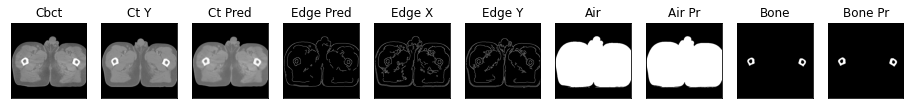

30it [00:12,  2.19it/s]

ssim score = 0.8875467777252197
psnr score = 25.172807693481445
snr score = 16.671672821044922
mae error = 0.0193913783878088
air dice score = 0.9976546930442828
bone dice score = 0.9634311512423605
contour dice score = 0.4960070848464966
edge dice score = 0.4240783154964447


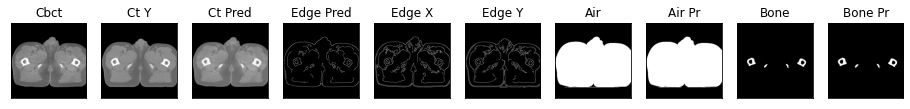

31it [00:13,  2.27it/s]

ssim score = 0.8940579891204834
psnr score = 25.687297821044922
snr score = 17.34872055053711
mae error = 0.019924087449908257
air dice score = 0.9988581785228824
bone dice score = 0.9784557320336774
contour dice score = 0.5163068175315857
edge dice score = 0.37220999598503113


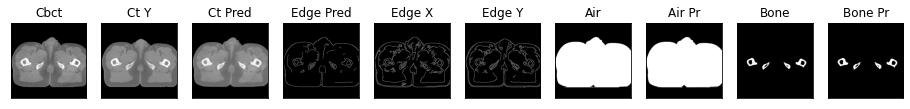

32it [00:13,  2.31it/s]

ssim score = 0.8962323665618896
psnr score = 25.94971466064453
snr score = 17.73927879333496
mae error = 0.020761171355843544
air dice score = 0.9990437643209831
bone dice score = 0.9716027150578805
contour dice score = 0.4846796691417694
edge dice score = 0.3661397099494934


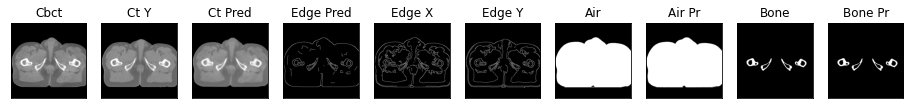

33it [00:13,  2.37it/s]

ssim score = 0.8978160619735718
psnr score = 26.30112648010254
snr score = 18.193927764892578
mae error = 0.021454473957419395
air dice score = 0.9991852091496225
bone dice score = 0.9628727936705674
contour dice score = 0.4990706443786621
edge dice score = 0.35389384627342224


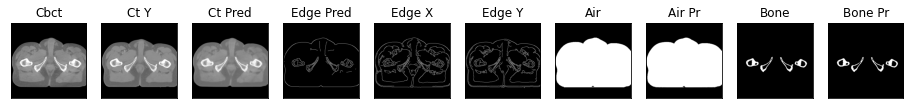

34it [00:14,  2.43it/s]

ssim score = 0.8998695611953735
psnr score = 26.558074951171875
snr score = 18.517976760864258
mae error = 0.022158605977892876
air dice score = 0.9991107822132577
bone dice score = 0.9492143019819037
contour dice score = 0.4681839346885681
edge dice score = 0.3889157176017761


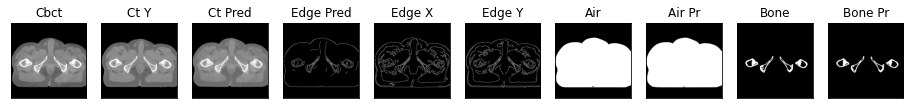

35it [00:14,  2.43it/s]

ssim score = 0.8990305662155151
psnr score = 26.668533325195312
snr score = 18.618547439575195
mae error = 0.021761367097496986
air dice score = 0.9990954319312534
bone dice score = 0.9524321997422253
contour dice score = 0.500231146812439
edge dice score = 0.3742964267730713


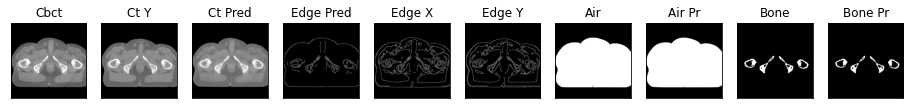

36it [00:15,  2.45it/s]

ssim score = 0.9028778076171875
psnr score = 26.852752685546875
snr score = 18.78910255432129
mae error = 0.021190723404288292
air dice score = 0.9991804641660931
bone dice score = 0.9587497342126435
contour dice score = 0.48681166768074036
edge dice score = 0.34597575664520264


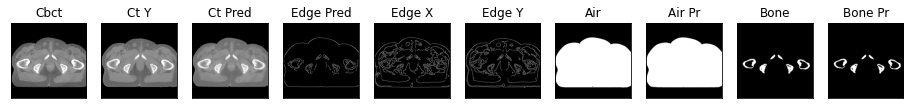

37it [00:15,  2.45it/s]

ssim score = 0.9051575660705566
psnr score = 27.099834442138672
snr score = 19.04818344116211
mae error = 0.021139046177268028
air dice score = 0.9991754411982802
bone dice score = 0.9500000000005656
contour dice score = 0.49884098768234253
edge dice score = 0.3726648986339569


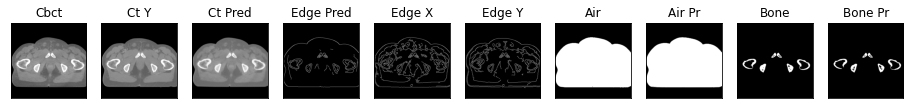

38it [00:15,  2.44it/s]

ssim score = 0.9055494666099548
psnr score = 27.009065628051758
snr score = 18.996498107910156
mae error = 0.02156849578022957
air dice score = 0.9992291911250256
bone dice score = 0.9514428091325595
contour dice score = 0.4934823215007782
edge dice score = 0.3902687430381775


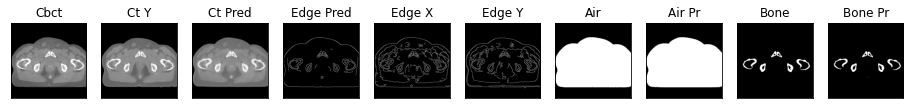

39it [00:16,  2.42it/s]

ssim score = 0.903251051902771
psnr score = 26.47223663330078
snr score = 18.600961685180664
mae error = 0.024382788687944412
air dice score = 0.9992171654271791
bone dice score = 0.9299918831175934
contour dice score = 0.49766573309898376
edge dice score = 0.35764747858047485


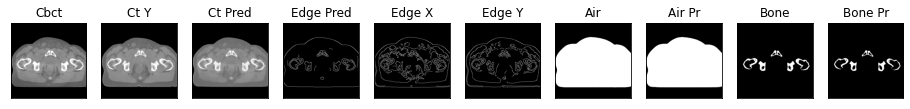

40it [00:16,  2.10it/s]

ssim score = 0.9022458791732788
psnr score = 26.091318130493164
snr score = 18.314727783203125
mae error = 0.026572391390800476
air dice score = 0.9992934876182225
bone dice score = 0.8940972222231415
contour dice score = 0.45952269434928894
edge dice score = 0.3888486623764038


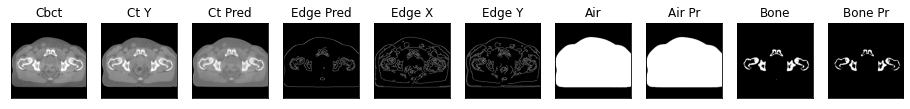

41it [00:17,  2.20it/s]

ssim score = 0.8936710953712463
psnr score = 25.636249542236328
snr score = 17.825611114501953
mae error = 0.02680767886340618
air dice score = 0.9990052359139624
bone dice score = 0.8484742502417726
contour dice score = 0.4763687551021576
edge dice score = 0.4115643799304962


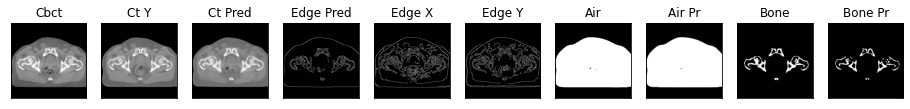

42it [00:17,  2.27it/s]

ssim score = 0.8905288577079773
psnr score = 24.681379318237305
snr score = 16.942928314208984
mae error = 0.02919582836329937
air dice score = 0.9985683564852261
bone dice score = 0.7723821575468809
contour dice score = 0.478342741727829
edge dice score = 0.42366811633110046


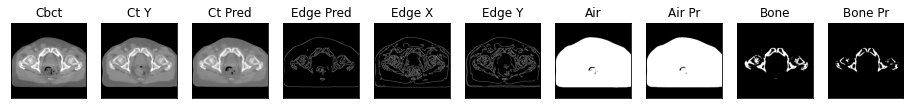

43it [00:18,  2.34it/s]

ssim score = 0.890876293182373
psnr score = 25.0531005859375
snr score = 17.178556442260742
mae error = 0.026917167007923126
air dice score = 0.9987315061410741
bone dice score = 0.8288921425102109
contour dice score = 0.47547170519828796
edge dice score = 0.4080061614513397


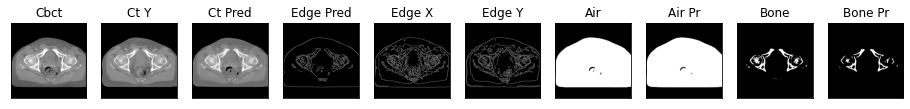

44it [00:18,  2.40it/s]

ssim score = 0.8942775130271912
psnr score = 25.523393630981445
snr score = 17.470287322998047
mae error = 0.02381221391260624
air dice score = 0.9989445560199516
bone dice score = 0.8639391056151395
contour dice score = 0.5082820653915405
edge dice score = 0.3945100009441376


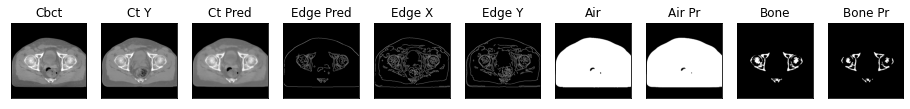

45it [00:18,  2.45it/s]

ssim score = 0.8940306901931763
psnr score = 25.968549728393555
snr score = 17.82485580444336
mae error = 0.022366099059581757
air dice score = 0.9991059886678029
bone dice score = 0.8748680661443078
contour dice score = 0.4876425862312317
edge dice score = 0.3950721323490143


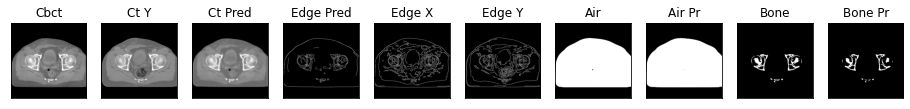

46it [00:19,  2.44it/s]

ssim score = 0.8938865065574646
psnr score = 25.89583969116211
snr score = 17.767833709716797
mae error = 0.022546598687767982
air dice score = 0.9991808003883618
bone dice score = 0.8823723229007976
contour dice score = 0.5216976404190063
edge dice score = 0.390399694442749


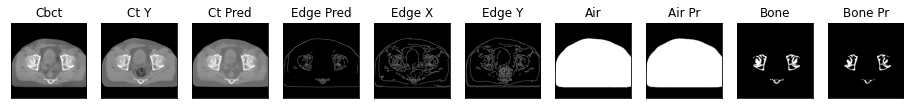

47it [00:19,  2.41it/s]

ssim score = 0.8818674087524414
psnr score = 25.576427459716797
snr score = 17.458457946777344
mae error = 0.02378910221159458
air dice score = 0.9990789706429523
bone dice score = 0.881386316105155
contour dice score = 0.5097851753234863
edge dice score = 0.3975268304347992


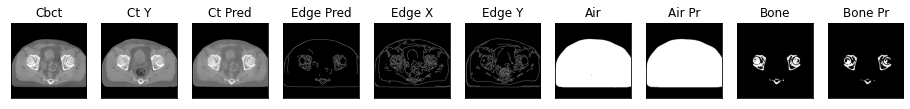

48it [00:20,  2.43it/s]

ssim score = 0.8886807560920715
psnr score = 25.752513885498047
snr score = 17.69613265991211
mae error = 0.024110373109579086
air dice score = 0.9990268384490626
bone dice score = 0.8895360124258441
contour dice score = 0.540772557258606
edge dice score = 0.32168519496917725


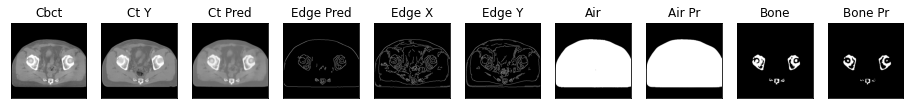

49it [00:20,  2.14it/s]

ssim score = 0.8904600143432617
psnr score = 25.924636840820312
snr score = 17.938339233398438
mae error = 0.02510112151503563
air dice score = 0.9988590916897718
bone dice score = 0.9326747164294487
contour dice score = 0.522153377532959
edge dice score = 0.33594197034835815


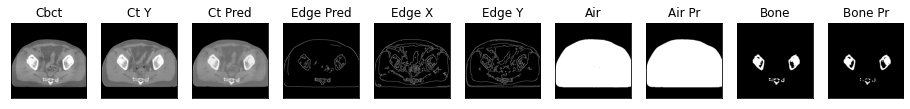

50it [00:21,  2.24it/s]

ssim score = 0.8960742950439453
psnr score = 26.04545783996582
snr score = 17.940052032470703
mae error = 0.023105576634407043
air dice score = 0.9988223459849366
bone dice score = 0.9143092274466176
contour dice score = 0.535748302936554
edge dice score = 0.3581130802631378


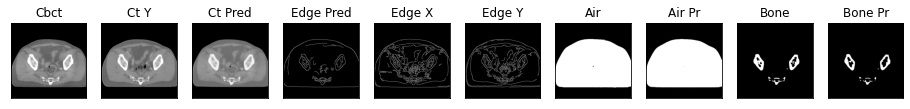

51it [00:21,  2.29it/s]

ssim score = 0.889870285987854
psnr score = 25.233779907226562
snr score = 17.210004806518555
mae error = 0.02570834755897522
air dice score = 0.9985598637079535
bone dice score = 0.9079267742816491
contour dice score = 0.5129186511039734
edge dice score = 0.3820183277130127


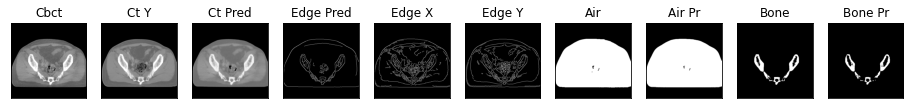

52it [00:21,  2.32it/s]

ssim score = 0.8890246152877808
psnr score = 25.116783142089844
snr score = 17.173152923583984
mae error = 0.02717241458594799
air dice score = 0.9984346145849904
bone dice score = 0.86834076507965
contour dice score = 0.46109509468078613
edge dice score = 0.3960486650466919


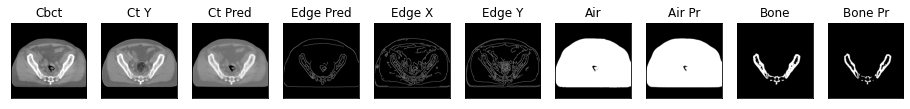

53it [00:22,  2.34it/s]

ssim score = 0.873424232006073
psnr score = 24.582504272460938
snr score = 16.660432815551758
mae error = 0.02844073995947838
air dice score = 0.9984561780337942
bone dice score = 0.8523938285362462
contour dice score = 0.44048193097114563
edge dice score = 0.4093781113624573


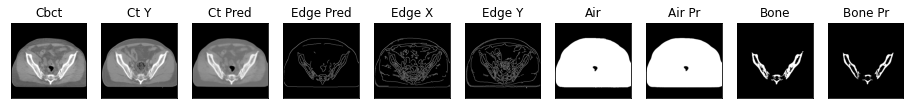

54it [00:22,  2.33it/s]

ssim score = 0.8754792809486389
psnr score = 25.238052368164062
snr score = 17.32851791381836
mae error = 0.02761765383183956
air dice score = 0.998420049032962
bone dice score = 0.8644027167409956
contour dice score = 0.41634616255760193
edge dice score = 0.42055028676986694


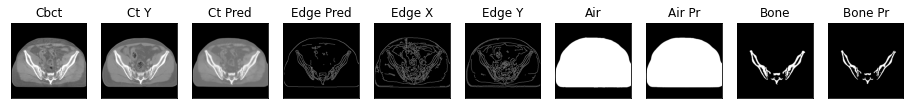

55it [00:23,  2.36it/s]

ssim score = 0.8089408278465271
psnr score = 21.08492660522461
snr score = 10.96513557434082
mae error = 0.03281162306666374
air dice score = 0.997944887236858
bone dice score = 0.9393316195388347
contour dice score = 0.5433462262153625
edge dice score = 0.3927576541900635


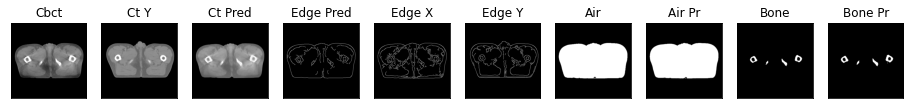

56it [00:23,  2.42it/s]

ssim score = 0.8005309700965881
psnr score = 20.873720169067383
snr score = 10.966910362243652
mae error = 0.03385106474161148
air dice score = 0.9982858919134968
bone dice score = 0.9321930360429201
contour dice score = 0.49394938349723816
edge dice score = 0.40736451745033264


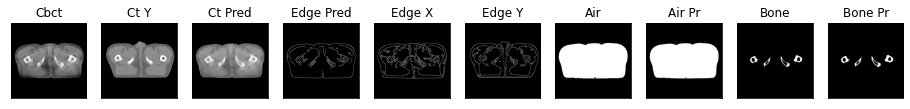

57it [00:24,  2.47it/s]

ssim score = 0.7977990508079529
psnr score = 20.902206420898438
snr score = 11.126535415649414
mae error = 0.034003615379333496
air dice score = 0.9983391052371207
bone dice score = 0.9195093905726426
contour dice score = 0.5264882445335388
edge dice score = 0.45072364807128906


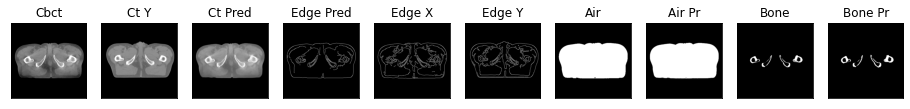

58it [00:24,  2.49it/s]

ssim score = 0.8013720512390137
psnr score = 21.19452476501465
snr score = 11.489253044128418
mae error = 0.03295325115323067
air dice score = 0.9981550463874067
bone dice score = 0.9164370982568147
contour dice score = 0.451259583234787
edge dice score = 0.47002941370010376


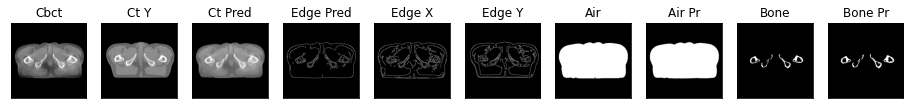

59it [00:24,  2.18it/s]

ssim score = 0.8005359172821045
psnr score = 21.26630973815918
snr score = 11.60860824584961
mae error = 0.032842740416526794
air dice score = 0.9977055382351931
bone dice score = 0.9201995012483043
contour dice score = 0.5049073100090027
edge dice score = 0.41904324293136597


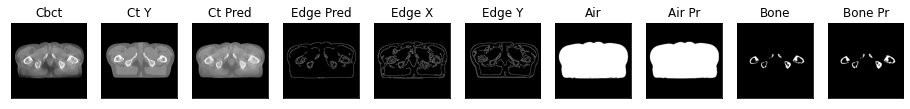

60it [00:25,  2.28it/s]

ssim score = 0.7986000180244446
psnr score = 21.401554107666016
snr score = 11.749466896057129
mae error = 0.032363925129175186
air dice score = 0.9974085804779752
bone dice score = 0.9340369393151444
contour dice score = 0.5138004422187805
edge dice score = 0.38436266779899597


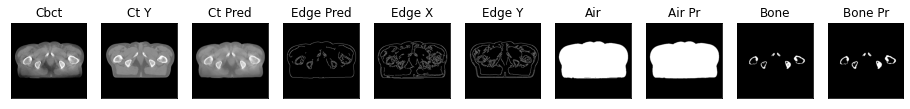

61it [00:25,  2.33it/s]

ssim score = 0.8011491894721985
psnr score = 21.43354606628418
snr score = 11.774955749511719
mae error = 0.03198107331991196
air dice score = 0.9973739587137638
bone dice score = 0.9375112551785069
contour dice score = 0.5265957713127136
edge dice score = 0.38351961970329285


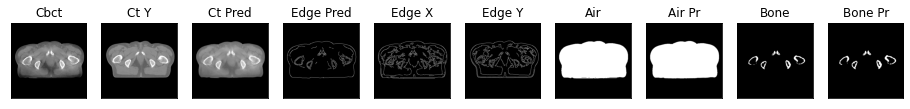

62it [00:26,  2.38it/s]

ssim score = 0.8023198246955872
psnr score = 21.29704475402832
snr score = 11.652565002441406
mae error = 0.03221103549003601
air dice score = 0.9972864016645738
bone dice score = 0.9476300372812422
contour dice score = 0.48407644033432007
edge dice score = 0.4100336730480194


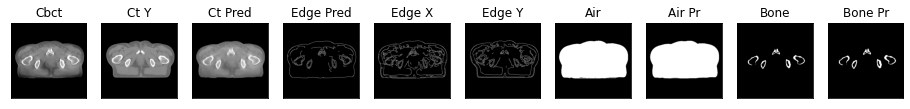

63it [00:26,  2.40it/s]

ssim score = 0.8006438612937927
psnr score = 21.1805419921875
snr score = 11.594070434570312
mae error = 0.0332668200135231
air dice score = 0.997210865497889
bone dice score = 0.9432216905910172
contour dice score = 0.5314834713935852
edge dice score = 0.41425585746765137


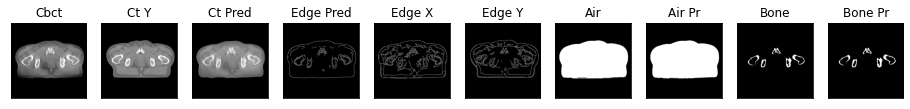

64it [00:26,  2.44it/s]

ssim score = 0.7944151163101196
psnr score = 21.013282775878906
snr score = 11.525369644165039
mae error = 0.03479832038283348
air dice score = 0.9968214483139883
bone dice score = 0.9349544072958214
contour dice score = 0.5300950407981873
edge dice score = 0.4587886929512024


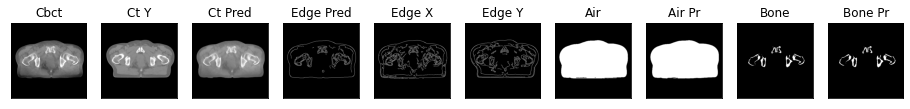

65it [00:27,  2.44it/s]

ssim score = 0.7857531905174255
psnr score = 20.9072322845459
snr score = 11.455148696899414
mae error = 0.036110181361436844
air dice score = 0.9969735900464766
bone dice score = 0.9269225113964575
contour dice score = 0.480386883020401
edge dice score = 0.4557718336582184


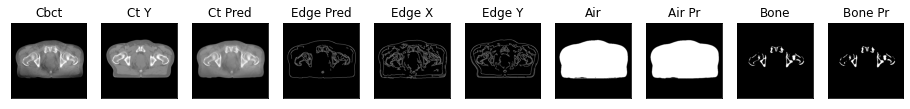

66it [00:27,  2.47it/s]

ssim score = 0.7768195867538452
psnr score = 20.820920944213867
snr score = 11.401543617248535
mae error = 0.03651424124836922
air dice score = 0.9972692423655104
bone dice score = 0.8959561343400143
contour dice score = 0.5449678897857666
edge dice score = 0.4645530879497528


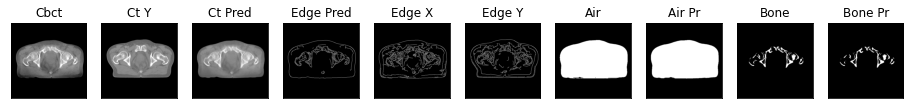

67it [00:28,  2.44it/s]

ssim score = 0.7771962285041809
psnr score = 20.885921478271484
snr score = 11.583358764648438
mae error = 0.03621673956513405
air dice score = 0.9976401281565459
bone dice score = 0.9283608868393136
contour dice score = 0.6244725584983826
edge dice score = 0.4546477198600769


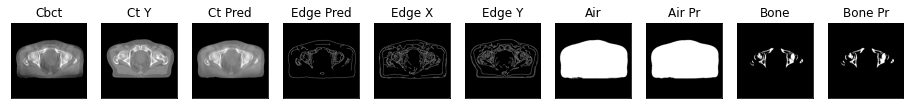

68it [00:28,  2.14it/s]

ssim score = 0.7802649736404419
psnr score = 20.88817596435547
snr score = 11.56962776184082
mae error = 0.035872913897037506
air dice score = 0.998002342081699
bone dice score = 0.915032679739719
contour dice score = 0.5952121615409851
edge dice score = 0.4337298572063446


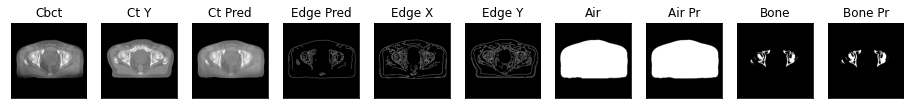

69it [00:29,  2.23it/s]

ssim score = 0.7946159243583679
psnr score = 21.381065368652344
snr score = 11.86335563659668
mae error = 0.03313491493463516
air dice score = 0.9981158535011588
bone dice score = 0.9222992489901459
contour dice score = 0.6430488228797913
edge dice score = 0.41004183888435364


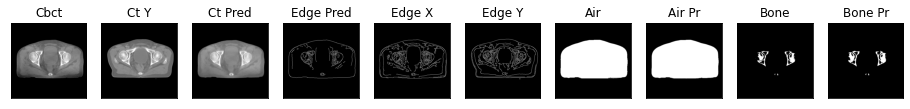

70it [00:29,  2.30it/s]

ssim score = 0.812165379524231
psnr score = 22.03556251525879
snr score = 12.347458839416504
mae error = 0.030417585745453835
air dice score = 0.9979898634137978
bone dice score = 0.9349112426044256
contour dice score = 0.608180820941925
edge dice score = 0.4001779556274414


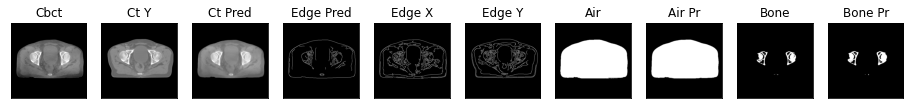

71it [00:30,  2.35it/s]

ssim score = 0.8200939297676086
psnr score = 22.44445037841797
snr score = 12.770514488220215
mae error = 0.029046999290585518
air dice score = 0.997796582559567
bone dice score = 0.9520163348653392
contour dice score = 0.625
edge dice score = 0.4086416959762573


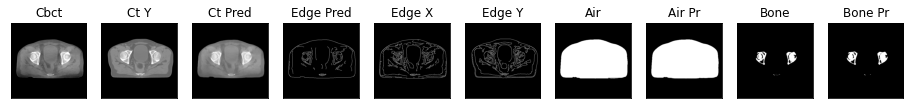

72it [00:30,  2.37it/s]

ssim score = 0.8247858285903931
psnr score = 22.71937370300293
snr score = 13.127265930175781
mae error = 0.028391288593411446
air dice score = 0.998221218807192
bone dice score = 0.9633027522940589
contour dice score = 0.6109603643417358
edge dice score = 0.338245153427124


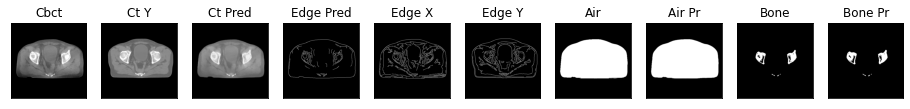

73it [00:30,  2.42it/s]

ssim score = 0.8234015107154846
psnr score = 22.652908325195312
snr score = 13.152971267700195
mae error = 0.029424386098980904
air dice score = 0.998217560018764
bone dice score = 0.9415322580653581
contour dice score = 0.603960394859314
edge dice score = 0.3633577823638916


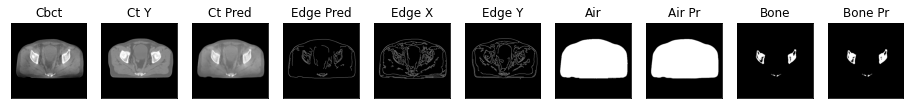

74it [00:31,  2.45it/s]

ssim score = 0.8182388544082642
psnr score = 22.952552795410156
snr score = 13.389191627502441
mae error = 0.028354261070489883
air dice score = 0.9979352009992625
bone dice score = 0.9524872448987167
contour dice score = 0.6448497772216797
edge dice score = 0.369590163230896


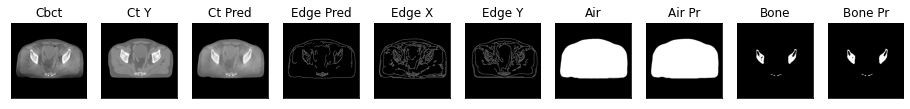

75it [00:31,  2.46it/s]

ssim score = 0.8223830461502075
psnr score = 23.082202911376953
snr score = 13.48244857788086
mae error = 0.02754727192223072
air dice score = 0.9976393865801695
bone dice score = 0.953480358374337
contour dice score = 0.6126797795295715
edge dice score = 0.3868701159954071


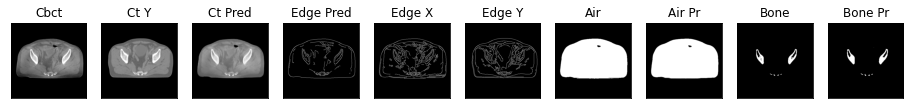

76it [00:32,  2.45it/s]

ssim score = 0.8203151822090149
psnr score = 22.890703201293945
snr score = 13.328694343566895
mae error = 0.028661463409662247
air dice score = 0.9976814695915839
bone dice score = 0.945907132600193
contour dice score = 0.6068965792655945
edge dice score = 0.40898141264915466


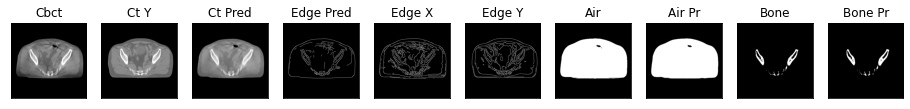

77it [00:32,  2.48it/s]

ssim score = 0.8189600110054016
psnr score = 22.88347625732422
snr score = 13.451972961425781
mae error = 0.029050592333078384
air dice score = 0.9978069429805193
bone dice score = 0.9494920589505009
contour dice score = 0.6520577073097229
edge dice score = 0.4471369683742523


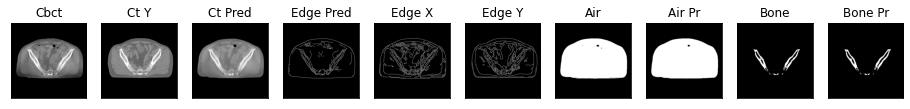

78it [00:33,  2.16it/s]

ssim score = 0.820941686630249
psnr score = 22.733333587646484
snr score = 13.31957721710205
mae error = 0.02962356247007847
air dice score = 0.9976959311851467
bone dice score = 0.9301310043679019
contour dice score = 0.6039763689041138
edge dice score = 0.47898221015930176


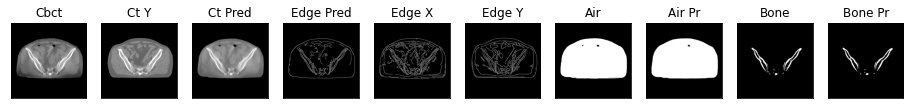

79it [00:33,  2.25it/s]

ssim score = 0.8247501254081726
psnr score = 23.21338653564453
snr score = 13.788362503051758
mae error = 0.028390521183609962
air dice score = 0.9979005458580787
bone dice score = 0.9388513513523843
contour dice score = 0.6004319787025452
edge dice score = 0.4579249918460846


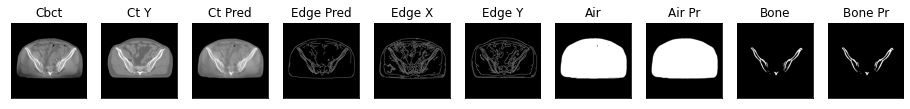

80it [00:33,  2.32it/s]

ssim score = 0.8283432722091675
psnr score = 23.31794548034668
snr score = 13.892178535461426
mae error = 0.027887143194675446
air dice score = 0.9980731182795716
bone dice score = 0.9347056931499725
contour dice score = 0.5991285443305969
edge dice score = 0.47713401913642883


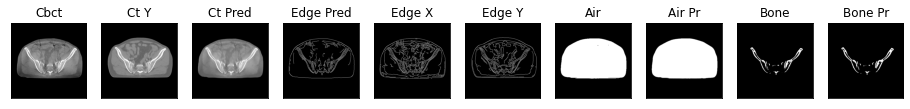

81it [00:34,  2.40it/s]

ssim score = 0.8792137503623962
psnr score = 23.953670501708984
snr score = 14.387805938720703
mae error = 0.021257568150758743
air dice score = 0.9975946604648218
bone dice score = 0.8990250696413988
contour dice score = 0.46652495861053467
edge dice score = 0.4472807049751282


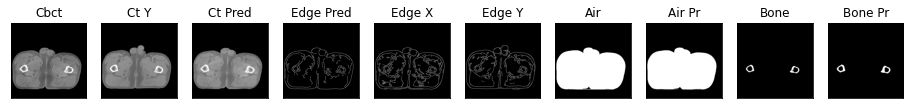

82it [00:34,  2.43it/s]

ssim score = 0.8805381059646606
psnr score = 24.335220336914062
snr score = 14.833745002746582
mae error = 0.020405910909175873
air dice score = 0.9976427407489459
bone dice score = 0.887208569631783
contour dice score = 0.4220472574234009
edge dice score = 0.44326719641685486


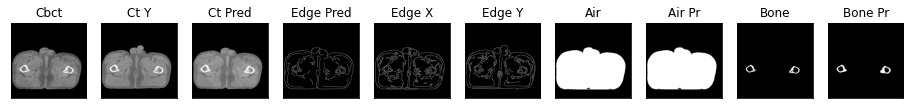

83it [00:35,  2.44it/s]

ssim score = 0.8899086713790894
psnr score = 26.180770874023438
snr score = 16.81850814819336
mae error = 0.01736590452492237
air dice score = 0.9980686376467107
bone dice score = 0.9230123767584851
contour dice score = 0.505840539932251
edge dice score = 0.4067200720310211


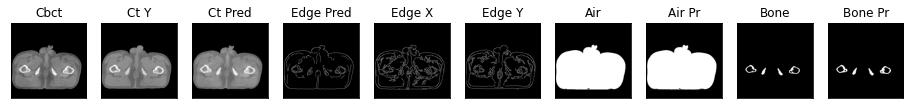

84it [00:35,  2.46it/s]

ssim score = 0.8910109996795654
psnr score = 26.309146881103516
snr score = 17.068376541137695
mae error = 0.01732449233531952
air dice score = 0.9986308190191696
bone dice score = 0.9118881118898724
contour dice score = 0.5370370149612427
edge dice score = 0.40990638732910156


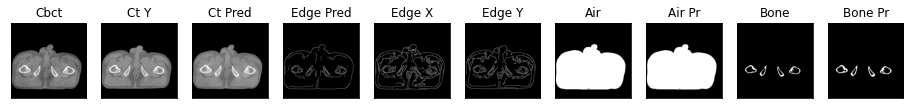

85it [00:35,  2.41it/s]

ssim score = 0.8873674273490906
psnr score = 26.15701675415039
snr score = 16.940418243408203
mae error = 0.01746046170592308
air dice score = 0.9986262137052657
bone dice score = 0.9059089973253879
contour dice score = 0.5290456414222717
edge dice score = 0.4175824224948883


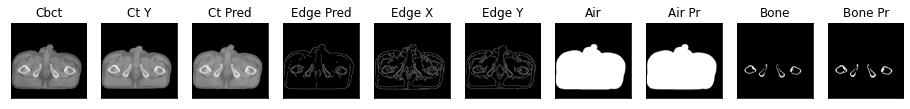

86it [00:36,  2.45it/s]

ssim score = 0.8871226906776428
psnr score = 25.917724609375
snr score = 16.696731567382812
mae error = 0.01770816184580326
air dice score = 0.9984102488542171
bone dice score = 0.9104984894276719
contour dice score = 0.5282427072525024
edge dice score = 0.4133008122444153


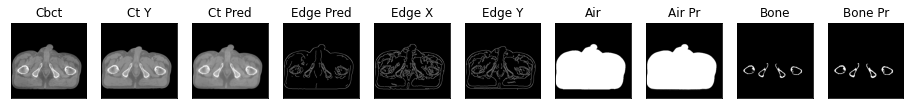

87it [00:36,  2.12it/s]

ssim score = 0.8869033455848694
psnr score = 25.359146118164062
snr score = 16.144407272338867
mae error = 0.018586715683341026
air dice score = 0.9980384403662627
bone dice score = 0.9196345329121828
contour dice score = 0.5023646950721741
edge dice score = 0.42805618047714233


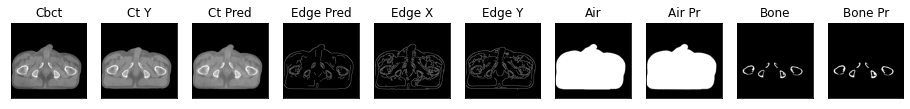

88it [00:37,  2.21it/s]

ssim score = 0.8843449950218201
psnr score = 25.047645568847656
snr score = 15.811351776123047
mae error = 0.018849574029445648
air dice score = 0.998199624404403
bone dice score = 0.9298278797062639
contour dice score = 0.5353003144264221
edge dice score = 0.3888888955116272


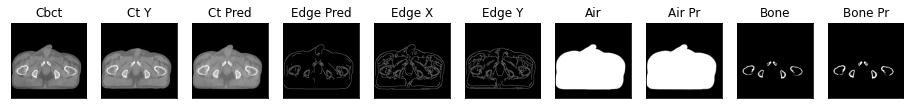

89it [00:37,  2.26it/s]

ssim score = 0.8852883577346802
psnr score = 25.09770393371582
snr score = 15.87831974029541
mae error = 0.018969345837831497
air dice score = 0.998093815403529
bone dice score = 0.9381258941355843
contour dice score = 0.4970853328704834
edge dice score = 0.38327813148498535


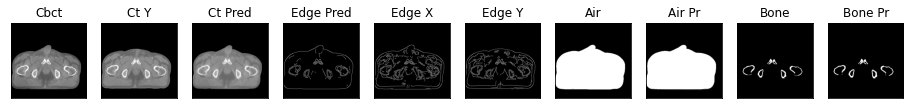

90it [00:38,  2.35it/s]

ssim score = 0.8867676258087158
psnr score = 25.471324920654297
snr score = 16.320533752441406
mae error = 0.018663568422198296
air dice score = 0.9982506833268269
bone dice score = 0.93741851369072
contour dice score = 0.5488520860671997
edge dice score = 0.39767986536026


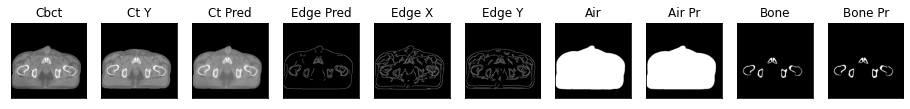

91it [00:38,  2.37it/s]

ssim score = 0.8882295489311218
psnr score = 25.897056579589844
snr score = 16.827625274658203
mae error = 0.01877211220562458
air dice score = 0.9984162079942306
bone dice score = 0.9392097264446928
contour dice score = 0.5301074981689453
edge dice score = 0.39486074447631836


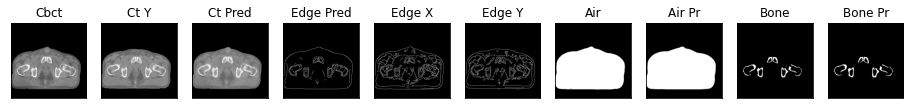

92it [00:38,  2.36it/s]

ssim score = 0.8910976648330688
psnr score = 26.43924331665039
snr score = 17.420513153076172
mae error = 0.018465906381607056
air dice score = 0.9987091899379792
bone dice score = 0.9268941072230558
contour dice score = 0.5806451439857483
edge dice score = 0.40087807178497314


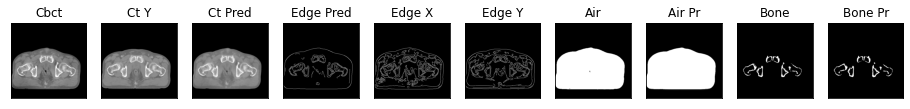

93it [00:39,  2.35it/s]

ssim score = 0.8935624957084656
psnr score = 26.679561614990234
snr score = 17.777101516723633
mae error = 0.01891619898378849
air dice score = 0.9988552300198172
bone dice score = 0.8786177105849011
contour dice score = 0.5454545617103577
edge dice score = 0.4317460358142853


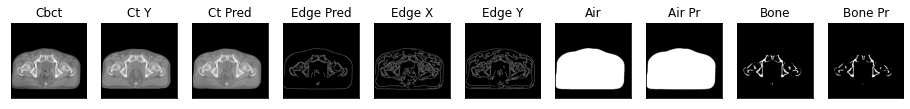

94it [00:39,  2.38it/s]

ssim score = 0.8922367691993713
psnr score = 26.149280548095703
snr score = 17.20858383178711
mae error = 0.018902387470006943
air dice score = 0.9989208062212356
bone dice score = 0.8917525773212287
contour dice score = 0.5309638977050781
edge dice score = 0.46067601442337036


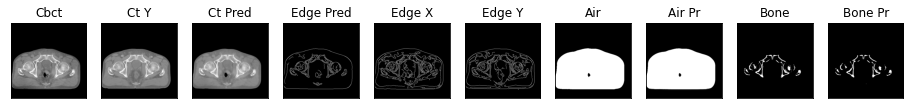

95it [00:40,  2.36it/s]

ssim score = 0.8848007917404175
psnr score = 25.27713966369629
snr score = 16.240774154663086
mae error = 0.019587859511375427
air dice score = 0.998512428420616
bone dice score = 0.8955555555570062
contour dice score = 0.4576362669467926
edge dice score = 0.4117211401462555


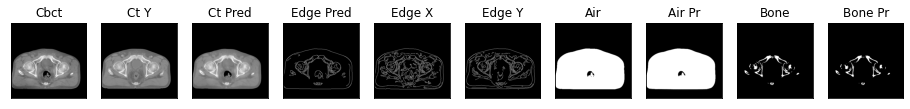

96it [00:40,  2.36it/s]

ssim score = 0.8873763084411621
psnr score = 25.013282775878906
snr score = 15.817155838012695
mae error = 0.019097017124295235
air dice score = 0.9984454163948172
bone dice score = 0.9195145320996564
contour dice score = 0.4577922224998474
edge dice score = 0.42108049988746643


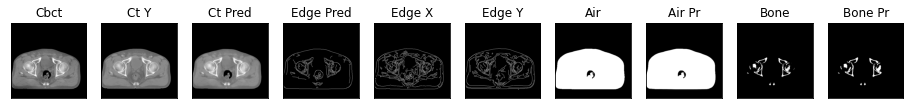

97it [00:41,  2.07it/s]

ssim score = 0.8862181305885315
psnr score = 24.576946258544922
snr score = 15.264394760131836
mae error = 0.019542258232831955
air dice score = 0.9981270053258212
bone dice score = 0.908508251884177
contour dice score = 0.43369564414024353
edge dice score = 0.41965869069099426


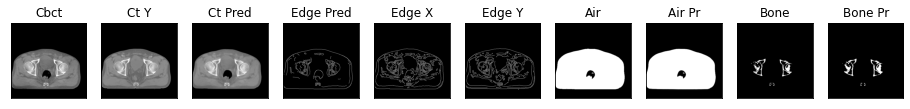

98it [00:41,  2.13it/s]

ssim score = 0.8821313977241516
psnr score = 24.440114974975586
snr score = 15.082468032836914
mae error = 0.01988966204226017
air dice score = 0.9981885988279183
bone dice score = 0.9352517985621421
contour dice score = 0.46212533116340637
edge dice score = 0.3840218782424927


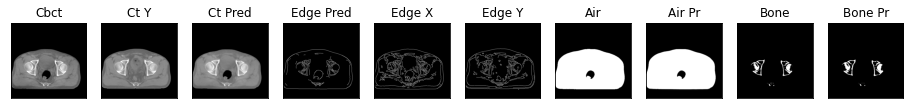

99it [00:42,  2.20it/s]

ssim score = 0.8751018643379211
psnr score = 23.876384735107422
snr score = 14.525413513183594
mae error = 0.021428409963846207
air dice score = 0.9982349995484897
bone dice score = 0.9454714929323369
contour dice score = 0.4688524603843689
edge dice score = 0.38937535881996155


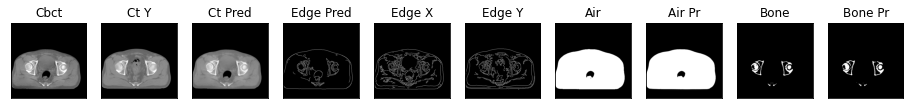

100it [00:42,  2.25it/s]

ssim score = 0.8765431642532349
psnr score = 23.52779769897461
snr score = 14.206932067871094
mae error = 0.022578973323106766
air dice score = 0.9984126070256546
bone dice score = 0.957935560859816
contour dice score = 0.4761904776096344
edge dice score = 0.3773339092731476


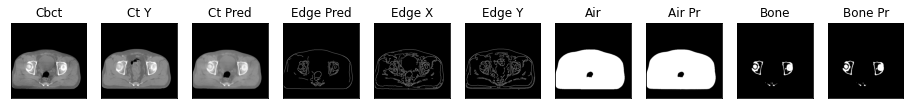

101it [00:42,  2.27it/s]

ssim score = 0.8816683888435364
psnr score = 24.256484985351562
snr score = 14.893031120300293
mae error = 0.020699497312307358
air dice score = 0.9978477310813937
bone dice score = 0.9473337722194316
contour dice score = 0.4789040982723236
edge dice score = 0.3812130391597748


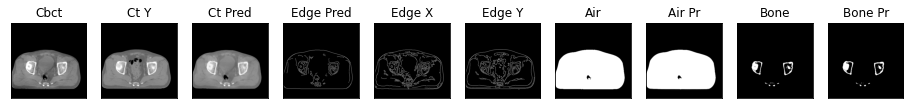

102it [00:43,  2.32it/s]

ssim score = 0.8839467763900757
psnr score = 24.583927154541016
snr score = 15.130267143249512
mae error = 0.019598597660660744
air dice score = 0.9976155705716875
bone dice score = 0.9358764759321366
contour dice score = 0.4739440381526947
edge dice score = 0.38664695620536804


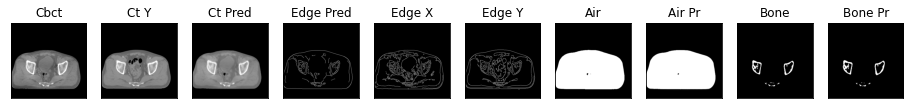

103it [00:43,  2.32it/s]

ssim score = 0.884200930595398
psnr score = 24.142417907714844
snr score = 14.62303352355957
mae error = 0.020167121663689613
air dice score = 0.997782261426358
bone dice score = 0.9481538167218643
contour dice score = 0.49560439586639404
edge dice score = 0.41087740659713745


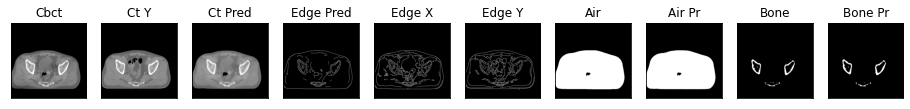

104it [00:44,  2.38it/s]

ssim score = 0.8818506598472595
psnr score = 24.228702545166016
snr score = 14.709014892578125
mae error = 0.020123843103647232
air dice score = 0.9974971023500382
bone dice score = 0.9551683302325297
contour dice score = 0.5038504004478455
edge dice score = 0.4151720106601715


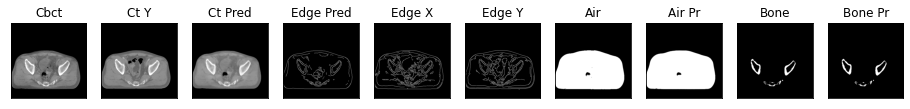

105it [00:44,  2.41it/s]

ssim score = 0.8773453831672668
psnr score = 24.187583923339844
snr score = 14.744063377380371
mae error = 0.02125168964266777
air dice score = 0.9978897410907259
bone dice score = 0.943865162120499
contour dice score = 0.5572139024734497
edge dice score = 0.4075287878513336


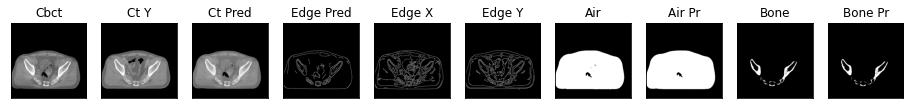

106it [00:45,  2.11it/s]

ssim score = 0.8817964792251587
psnr score = 24.439407348632812
snr score = 15.03146743774414
mae error = 0.020664989948272705
air dice score = 0.9981404077454592
bone dice score = 0.933224755701232
contour dice score = 0.5745856165885925
edge dice score = 0.412080317735672


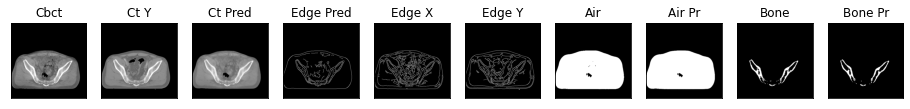

107it [00:45,  2.20it/s]

ssim score = 0.8820359706878662
psnr score = 25.14037322998047
snr score = 15.670738220214844
mae error = 0.019304350018501282
air dice score = 0.9978991416493043
bone dice score = 0.9170533642703443
contour dice score = 0.5482797026634216
edge dice score = 0.4261418879032135


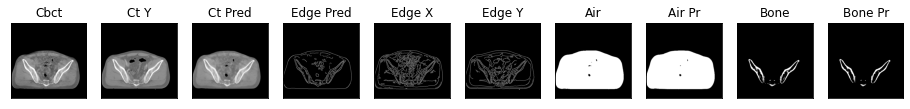

108it [00:46,  2.26it/s]

ssim score = 0.8769683241844177
psnr score = 24.870044708251953
snr score = 15.339147567749023
mae error = 0.01975092664361
air dice score = 0.9977782580505746
bone dice score = 0.9194813027756411
contour dice score = 0.4773109257221222
edge dice score = 0.4511815309524536


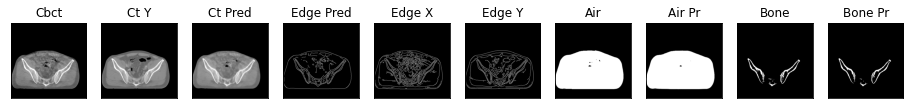

109it [00:46,  2.32it/s]

ssim score = 0.8035856485366821
psnr score = 22.566965103149414
snr score = 14.264269828796387
mae error = 0.03055441379547119
air dice score = 0.9988584947508509
bone dice score = 0.944726620856148
contour dice score = 0.5483443737030029
edge dice score = 0.372770756483078


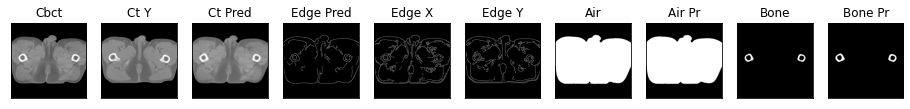

110it [00:46,  2.39it/s]

ssim score = 0.7966726422309875
psnr score = 22.267662048339844
snr score = 14.069257736206055
mae error = 0.031975168734788895
air dice score = 0.998275364792721
bone dice score = 0.9424055719276077
contour dice score = 0.5480427145957947
edge dice score = 0.3529287576675415


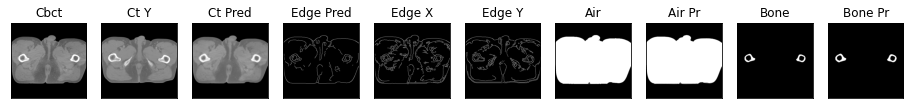

111it [00:47,  2.41it/s]

ssim score = 0.7932900786399841
psnr score = 21.966693878173828
snr score = 13.896247863769531
mae error = 0.03443112224340439
air dice score = 0.9982108183892683
bone dice score = 0.9231094212099047
contour dice score = 0.5514771938323975
edge dice score = 0.3343246877193451


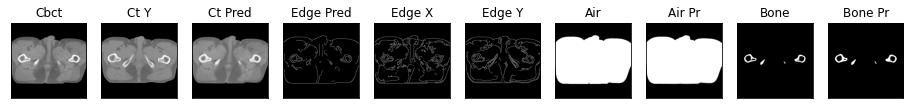

112it [00:47,  2.45it/s]

ssim score = 0.7876644730567932
psnr score = 21.612728118896484
snr score = 13.57457160949707
mae error = 0.03639345243573189
air dice score = 0.9984088542580707
bone dice score = 0.9550689375514182
contour dice score = 0.5343511700630188
edge dice score = 0.3074783384799957


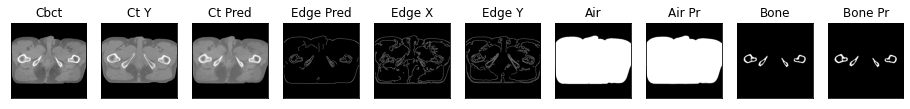

113it [00:48,  2.47it/s]

ssim score = 0.779502809047699
psnr score = 21.466354370117188
snr score = 13.458436965942383
mae error = 0.03749139979481697
air dice score = 0.9983428831499234
bone dice score = 0.9457120377663932
contour dice score = 0.5218961834907532
edge dice score = 0.36507323384284973


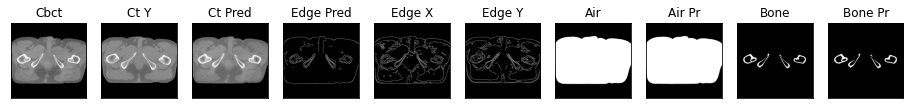

114it [00:48,  2.50it/s]

ssim score = 0.7735791206359863
psnr score = 21.30417823791504
snr score = 13.330677032470703
mae error = 0.038979608565568924
air dice score = 0.9985459536799013
bone dice score = 0.9486752460265151
contour dice score = 0.5427408218383789
edge dice score = 0.3955785930156708


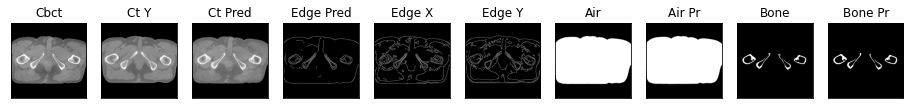

115it [00:48,  2.53it/s]

ssim score = 0.7663681507110596
psnr score = 20.991268157958984
snr score = 13.038074493408203
mae error = 0.04078061133623123
air dice score = 0.9982502694121611
bone dice score = 0.951904890570766
contour dice score = 0.5479082465171814
edge dice score = 0.3675484359264374


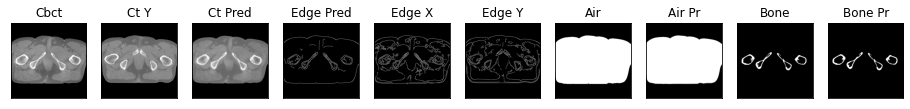

116it [00:49,  2.20it/s]

ssim score = 0.7663204073905945
psnr score = 21.005517959594727
snr score = 13.091398239135742
mae error = 0.040511421859264374
air dice score = 0.998410303545313
bone dice score = 0.9515454177358409
contour dice score = 0.5787348747253418
edge dice score = 0.3474259376525879


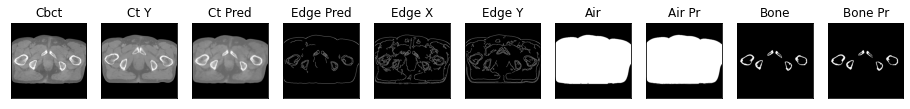

117it [00:49,  2.29it/s]

ssim score = 0.7667080163955688
psnr score = 21.083600997924805
snr score = 13.218162536621094
mae error = 0.04092945158481598
air dice score = 0.9982607288759465
bone dice score = 0.9462422401275097
contour dice score = 0.555169403553009
edge dice score = 0.33121487498283386


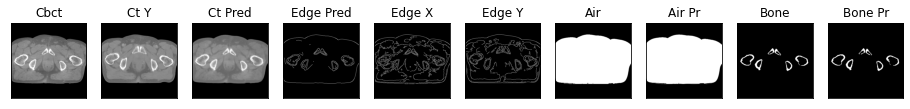

118it [00:50,  2.37it/s]

ssim score = 0.7601805925369263
psnr score = 20.888500213623047
snr score = 13.045673370361328
mae error = 0.04289203882217407
air dice score = 0.9978459352856602
bone dice score = 0.939971841802893
contour dice score = 0.5471537709236145
edge dice score = 0.3514028489589691


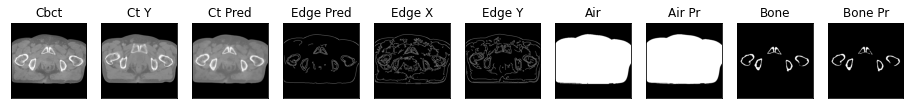

119it [00:50,  2.43it/s]

ssim score = 0.7483844757080078
psnr score = 20.791748046875
snr score = 12.99169635772705
mae error = 0.04468730092048645
air dice score = 0.998040526522051
bone dice score = 0.9243840271886832
contour dice score = 0.5799319744110107
edge dice score = 0.34677132964134216


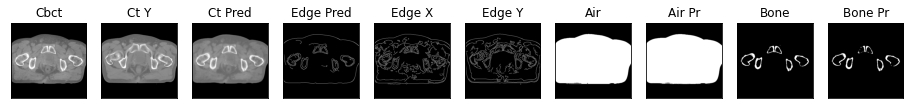

120it [00:50,  2.46it/s]

ssim score = 0.7500730752944946
psnr score = 20.7841854095459
snr score = 13.042473793029785
mae error = 0.04488549754023552
air dice score = 0.9985242013747331
bone dice score = 0.9191299498056985
contour dice score = 0.5446428656578064
edge dice score = 0.37658175826072693


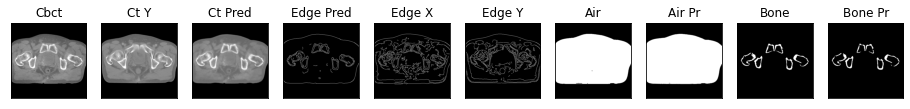

121it [00:51,  2.49it/s]

ssim score = 0.7457386255264282
psnr score = 20.70905303955078
snr score = 12.89197063446045
mae error = 0.04594382643699646
air dice score = 0.998828945706709
bone dice score = 0.8768253968267002
contour dice score = 0.5607223510742188
edge dice score = 0.40686163306236267


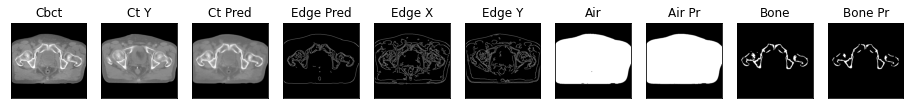

122it [00:51,  2.48it/s]

ssim score = 0.749437153339386
psnr score = 20.775882720947266
snr score = 12.851583480834961
mae error = 0.0454397015273571
air dice score = 0.9988001263024952
bone dice score = 0.8458606817716932
contour dice score = 0.5745553970336914
edge dice score = 0.4066248834133148


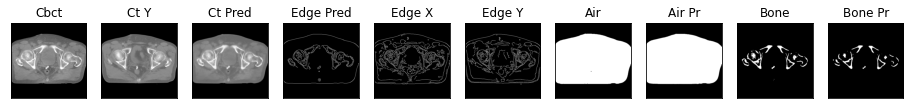

123it [00:52,  2.48it/s]

ssim score = 0.7599546909332275
psnr score = 21.07781410217285
snr score = 13.030425071716309
mae error = 0.043158479034900665
air dice score = 0.998815819728674
bone dice score = 0.8136173857208691
contour dice score = 0.6125630736351013
edge dice score = 0.3788546323776245


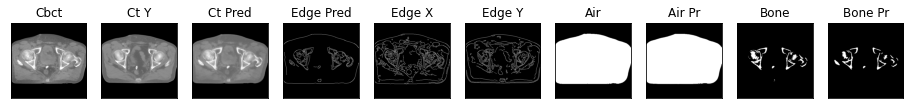

124it [00:52,  2.50it/s]

ssim score = 0.7642340660095215
psnr score = 21.274429321289062
snr score = 13.11461067199707
mae error = 0.04091425612568855
air dice score = 0.9989568625190912
bone dice score = 0.8781373491415344
contour dice score = 0.6362379193305969
edge dice score = 0.3724104166030884


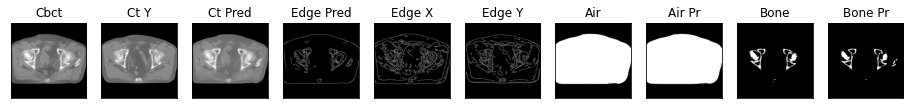

125it [00:53,  2.18it/s]

ssim score = 0.760016143321991
psnr score = 21.496662139892578
snr score = 13.286197662353516
mae error = 0.03813652694225311
air dice score = 0.998942422718841
bone dice score = 0.9275633042763848
contour dice score = 0.6234367489814758
edge dice score = 0.3681318759918213


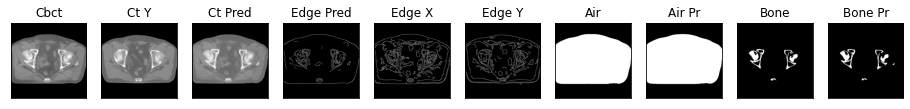

126it [00:53,  2.27it/s]

ssim score = 0.7604671716690063
psnr score = 21.314208984375
snr score = 13.13589859008789
mae error = 0.0393199659883976
air dice score = 0.998996758311539
bone dice score = 0.9348185728473054
contour dice score = 0.6576744318008423
edge dice score = 0.37857142090797424


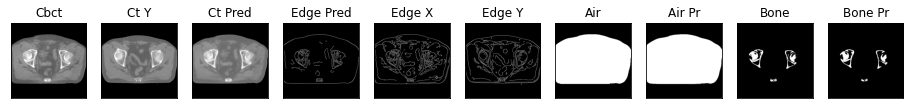

127it [00:53,  2.33it/s]

ssim score = 0.7597180604934692
psnr score = 21.088687896728516
snr score = 12.923855781555176
mae error = 0.04053707793354988
air dice score = 0.9989869939336079
bone dice score = 0.9393831974484297
contour dice score = 0.6358111500740051
edge dice score = 0.3629486560821533


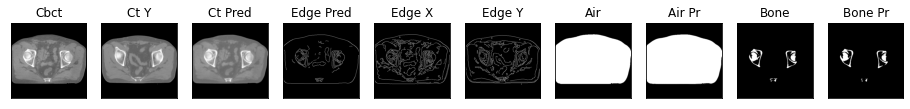

128it [00:54,  2.38it/s]

ssim score = 0.7569687962532043
psnr score = 20.81683921813965
snr score = 12.510514259338379
mae error = 0.0417790487408638
air dice score = 0.9988121222051232
bone dice score = 0.9345238095245889
contour dice score = 0.633364737033844
edge dice score = 0.33112582564353943


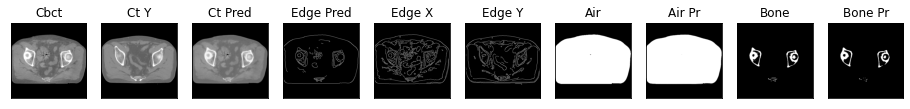

129it [00:54,  2.40it/s]

ssim score = 0.7648946046829224
psnr score = 20.87734031677246
snr score = 12.511707305908203
mae error = 0.04079930856823921
air dice score = 0.9988589577696748
bone dice score = 0.942689098619304
contour dice score = 0.6146572232246399
edge dice score = 0.3504660427570343


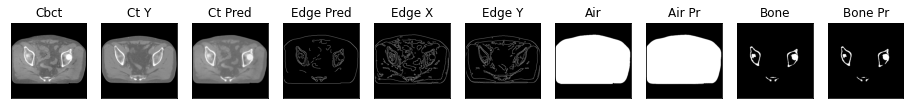

130it [00:55,  2.44it/s]

ssim score = 0.7593199610710144
psnr score = 21.14483642578125
snr score = 12.804849624633789
mae error = 0.03900664672255516
air dice score = 0.9988828928936627
bone dice score = 0.9234127706035399
contour dice score = 0.6121097207069397
edge dice score = 0.3846607804298401


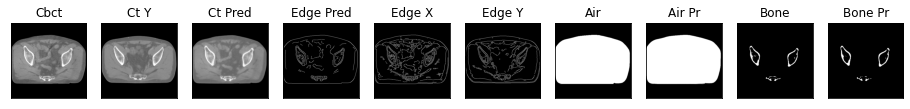

131it [00:55,  2.47it/s]

ssim score = 0.7537204623222351
psnr score = 21.020465850830078
snr score = 12.753292083740234
mae error = 0.03948334977030754
air dice score = 0.998722860791827
bone dice score = 0.9405737704928181
contour dice score = 0.5906294584274292
edge dice score = 0.3797014057636261


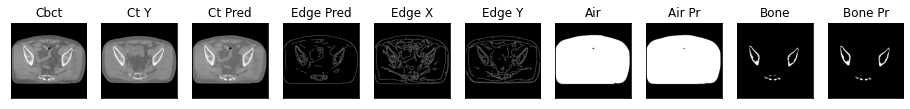

132it [00:55,  2.49it/s]

ssim score = 0.7465261816978455
psnr score = 20.617019653320312
snr score = 12.479077339172363
mae error = 0.04171871021389961
air dice score = 0.9988764716428621
bone dice score = 0.945244956773211
contour dice score = 0.6250595450401306
edge dice score = 0.3818424642086029


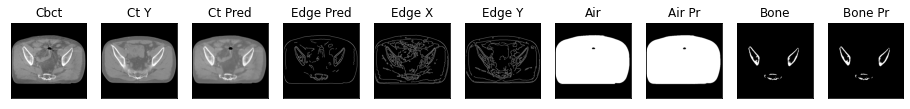

133it [00:56,  2.51it/s]

ssim score = 0.7424050569534302
psnr score = 20.46530532836914
snr score = 12.361322402954102
mae error = 0.04289377108216286
air dice score = 0.9987377076771424
bone dice score = 0.9437667360912858
contour dice score = 0.6177458167076111
edge dice score = 0.38912755250930786


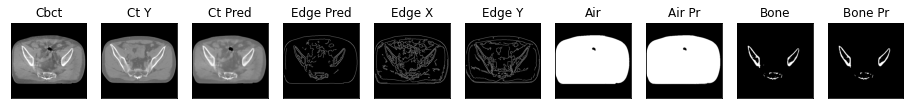

134it [00:56,  2.51it/s]

ssim score = 0.7336551547050476
psnr score = 20.49612045288086
snr score = 12.362348556518555
mae error = 0.04404374212026596
air dice score = 0.9987705955379858
bone dice score = 0.9149257488055006
contour dice score = 0.5897065997123718
edge dice score = 0.4150222837924957


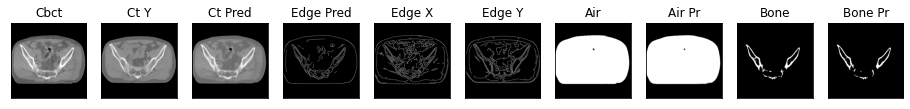

135it [00:57,  2.19it/s]

ssim score = 0.7315004467964172
psnr score = 20.762184143066406
snr score = 12.565034866333008
mae error = 0.04247725009918213
air dice score = 0.9988025979994928
bone dice score = 0.9019129019142327
contour dice score = 0.619990348815918
edge dice score = 0.40645211935043335


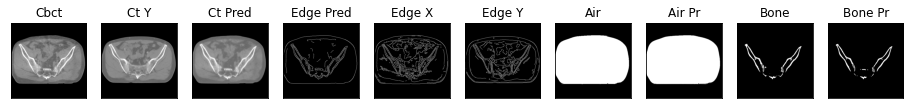

136it [00:57,  2.27it/s]

ssim score = 0.8497542142868042
psnr score = 23.236995697021484
snr score = 14.714387893676758
mae error = 0.028530899435281754
air dice score = 0.9986504523209264
bone dice score = 0.9200247985130809
contour dice score = 0.55706387758255
edge dice score = 0.3875843584537506


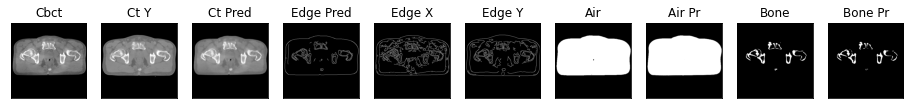

137it [00:58,  2.34it/s]

ssim score = 0.8543371558189392
psnr score = 23.285749435424805
snr score = 14.80315113067627
mae error = 0.02786097675561905
air dice score = 0.9986625453248539
bone dice score = 0.8995848469136016
contour dice score = 0.5254664421081543
edge dice score = 0.397033154964447


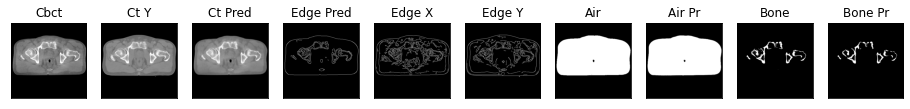

138it [00:58,  2.38it/s]

ssim score = 0.8547009825706482
psnr score = 23.466800689697266
snr score = 14.99199104309082
mae error = 0.027767637744545937
air dice score = 0.998817712012493
bone dice score = 0.8924833491927079
contour dice score = 0.5235443115234375
edge dice score = 0.41197362542152405


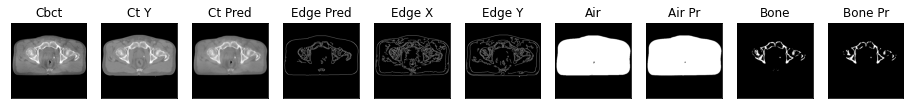

139it [00:58,  2.42it/s]

ssim score = 0.8593849539756775
psnr score = 23.454082489013672
snr score = 14.920852661132812
mae error = 0.026768729090690613
air dice score = 0.9987167052152512
bone dice score = 0.9027286508349832
contour dice score = 0.4832487404346466
edge dice score = 0.4068062901496887


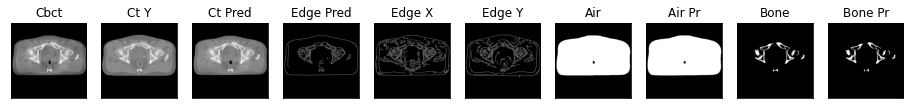

140it [00:59,  2.42it/s]

ssim score = 0.8648322224617004
psnr score = 23.638824462890625
snr score = 14.949974060058594
mae error = 0.024448400363326073
air dice score = 0.9987050025825103
bone dice score = 0.9132897603498433
contour dice score = 0.48089659214019775
edge dice score = 0.4100134074687958


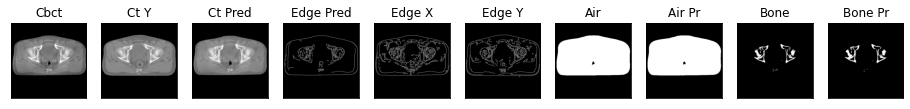

141it [00:59,  2.36it/s]

ssim score = 0.8680397272109985
psnr score = 23.77504539489746
snr score = 15.065391540527344
mae error = 0.023815076798200607
air dice score = 0.9985215205073372
bone dice score = 0.9257534246585514
contour dice score = 0.4864588677883148
edge dice score = 0.395925372838974


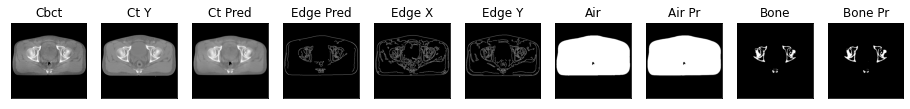

142it [01:00,  2.38it/s]

ssim score = 0.8633502721786499
psnr score = 23.75885009765625
snr score = 15.033561706542969
mae error = 0.024014245718717575
air dice score = 0.9984417461476514
bone dice score = 0.9325037197357974
contour dice score = 0.5274499654769897
edge dice score = 0.37034451961517334


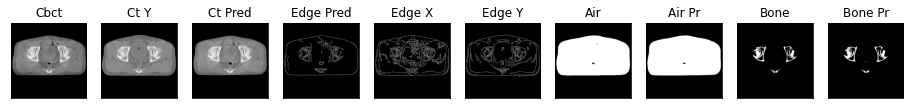

143it [01:00,  2.41it/s]

ssim score = 0.8555404543876648
psnr score = 23.092071533203125
snr score = 14.37614917755127
mae error = 0.02588389441370964
air dice score = 0.9983212595090831
bone dice score = 0.937955702298281
contour dice score = 0.5671641826629639
edge dice score = 0.39283275604248047


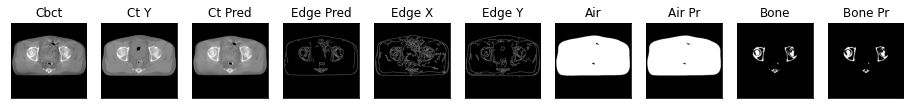

144it [01:01,  2.09it/s]

ssim score = 0.8509771227836609
psnr score = 23.261964797973633
snr score = 14.601821899414062
mae error = 0.026531150564551353
air dice score = 0.9980162936491126
bone dice score = 0.9445802770993673
contour dice score = 0.5240309834480286
edge dice score = 0.38566234707832336


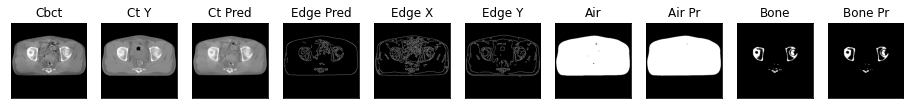

145it [01:01,  2.18it/s]

ssim score = 0.8487339615821838
psnr score = 22.707603454589844
snr score = 14.025530815124512
mae error = 0.028208889067173004
air dice score = 0.9981594438782508
bone dice score = 0.941027445461773
contour dice score = 0.5160955190658569
edge dice score = 0.3793870806694031


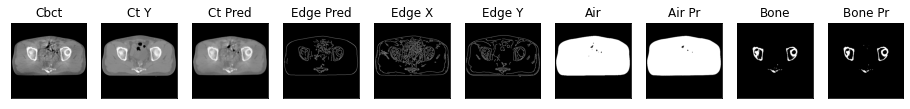

146it [01:02,  2.27it/s]

ssim score = 0.8487595319747925
psnr score = 22.19983673095703
snr score = 13.446990966796875
mae error = 0.028302902355790138
air dice score = 0.9983206619645214
bone dice score = 0.9246074926173697
contour dice score = 0.5049556493759155
edge dice score = 0.39840567111968994


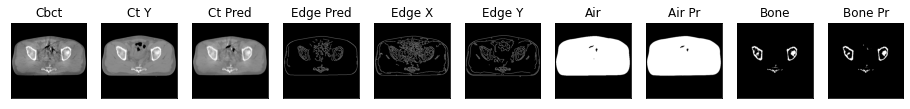

147it [01:02,  2.31it/s]

ssim score = 0.8505739569664001
psnr score = 22.570058822631836
snr score = 13.773321151733398
mae error = 0.027004161849617958
air dice score = 0.9984114376489289
bone dice score = 0.940274151437006
contour dice score = 0.5238344669342041
edge dice score = 0.3618590533733368


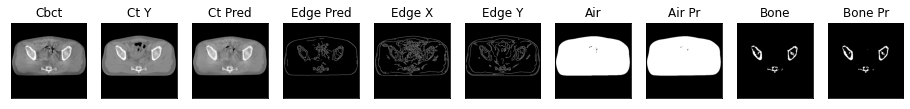

148it [01:02,  2.35it/s]

ssim score = 0.8512221574783325
psnr score = 22.781856536865234
snr score = 13.984020233154297
mae error = 0.026323676109313965
air dice score = 0.998114335648256
bone dice score = 0.9464314099515748
contour dice score = 0.5428721904754639
edge dice score = 0.3673710823059082


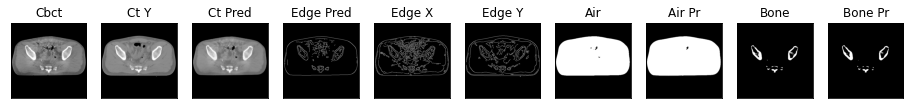

149it [01:03,  2.35it/s]

ssim score = 0.8456579446792603
psnr score = 22.866485595703125
snr score = 14.082006454467773
mae error = 0.026634439826011658
air dice score = 0.9976606027026214
bone dice score = 0.9506248095100484
contour dice score = 0.5144965648651123
edge dice score = 0.39910417795181274


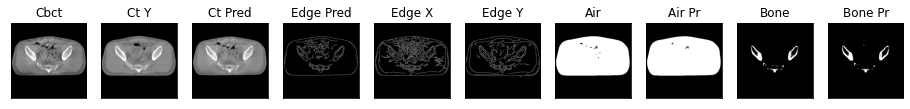

150it [01:03,  2.35it/s]

ssim score = 0.8434914946556091
psnr score = 22.686731338500977
snr score = 13.957457542419434
mae error = 0.028091520071029663
air dice score = 0.9978272803890809
bone dice score = 0.9398093745927691
contour dice score = 0.5438225865364075
edge dice score = 0.41001996397972107


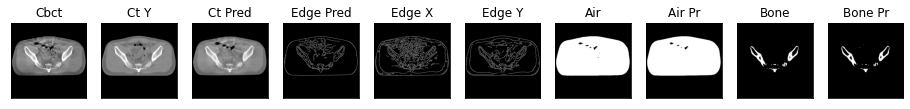

151it [01:04,  2.38it/s]

ssim score = 0.8441066741943359
psnr score = 22.182294845581055
snr score = 13.472390174865723
mae error = 0.02947661653161049
air dice score = 0.9981948759267738
bone dice score = 0.921734387783996
contour dice score = 0.5854949951171875
edge dice score = 0.44459664821624756


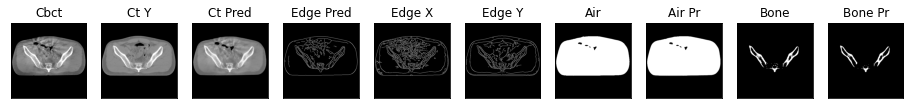

152it [01:04,  2.38it/s]

ssim score = 0.8494364619255066
psnr score = 22.431697845458984
snr score = 13.667054176330566
mae error = 0.027865419164299965
air dice score = 0.9977090137923579
bone dice score = 0.9160237388736495
contour dice score = 0.5169851183891296
edge dice score = 0.4581834673881531


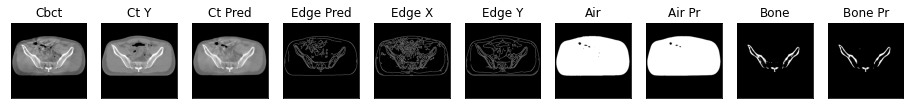

153it [01:04,  2.38it/s]

ssim score = 0.8516554236412048
psnr score = 22.696605682373047
snr score = 13.895608901977539
mae error = 0.02689374051988125
air dice score = 0.9978418100947609
bone dice score = 0.9067859806128742
contour dice score = 0.49893391132354736
edge dice score = 0.4718983471393585


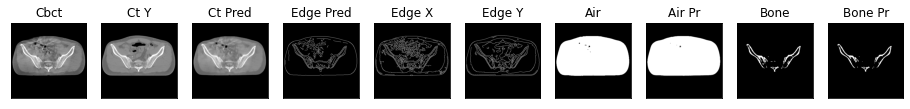

154it [01:05,  2.11it/s]

ssim score = 0.8562994003295898
psnr score = 22.862350463867188
snr score = 14.061427116394043
mae error = 0.02616387978196144
air dice score = 0.9974840722419646
bone dice score = 0.8979647218467033
contour dice score = 0.47405028343200684
edge dice score = 0.4742097854614258


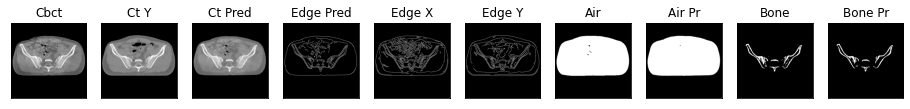

155it [01:05,  2.21it/s]

ssim score = 0.854939341545105
psnr score = 23.102455139160156
snr score = 14.30010986328125
mae error = 0.02575846202671528
air dice score = 0.998015596173823
bone dice score = 0.9063092336866192
contour dice score = 0.4833153784275055
edge dice score = 0.46399304270744324


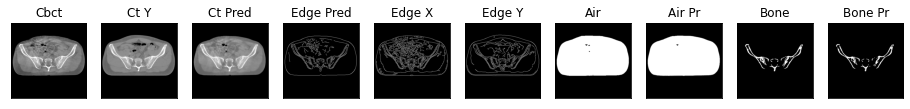

156it [01:06,  2.26it/s]

ssim score = 0.8446855545043945
psnr score = 22.5919132232666
snr score = 13.794607162475586
mae error = 0.02724914625287056
air dice score = 0.9980560480233911
bone dice score = 0.8961794019947926
contour dice score = 0.47727271914482117
edge dice score = 0.4722815155982971


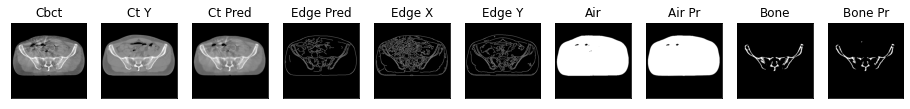

157it [01:06,  2.33it/s]

ssim score = 0.8374518752098083
psnr score = 21.999969482421875
snr score = 13.185388565063477
mae error = 0.028955157846212387
air dice score = 0.997414890542875
bone dice score = 0.8824678950323497
contour dice score = 0.4596949815750122
edge dice score = 0.4661085605621338


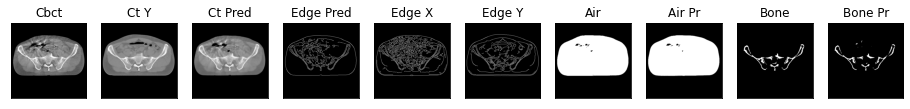

158it [01:07,  2.41it/s]

ssim score = 0.8332038521766663
psnr score = 21.67872428894043
snr score = 12.845521926879883
mae error = 0.02998269349336624
air dice score = 0.9976007903278938
bone dice score = 0.8671254632098051
contour dice score = 0.4572368562221527
edge dice score = 0.4922240376472473


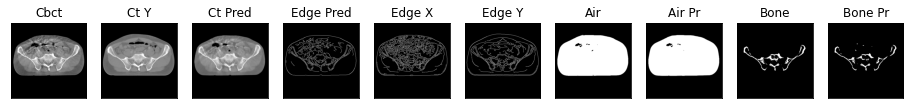

159it [01:07,  2.44it/s]

ssim score = 0.8236575126647949
psnr score = 21.264286041259766
snr score = 12.38514518737793
mae error = 0.031345561146736145
air dice score = 0.9974106109856227
bone dice score = 0.8738634908455133
contour dice score = 0.4483710527420044
edge dice score = 0.46573588252067566


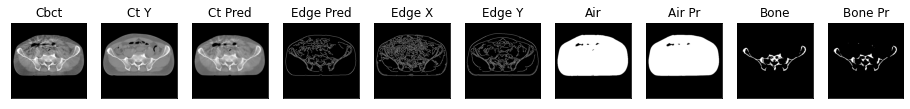

160it [01:07,  2.47it/s]

ssim score = 0.8181993365287781
psnr score = 21.28451156616211
snr score = 12.351570129394531
mae error = 0.0314926952123642
air dice score = 0.9972335952196547
bone dice score = 0.8890255905525465
contour dice score = 0.4062153100967407
edge dice score = 0.47740277647972107


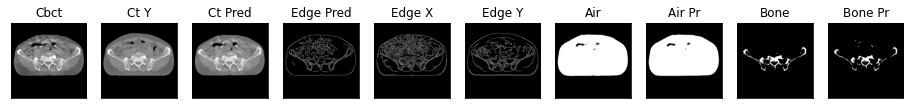

161it [01:08,  2.50it/s]

ssim score = 0.8114008903503418
psnr score = 20.934961318969727
snr score = 12.032485961914062
mae error = 0.03317725658416748
air dice score = 0.9968783014146959
bone dice score = 0.89980824544703
contour dice score = 0.3907028138637543
edge dice score = 0.4387270510196686


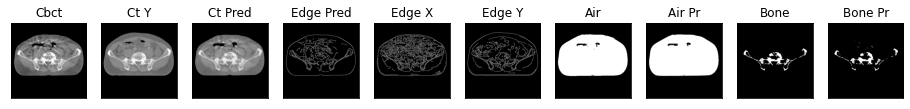

162it [01:08,  2.55it/s]

ssim score = 0.805082380771637
psnr score = 20.709627151489258
snr score = 11.75192642211914
mae error = 0.033278804272413254
air dice score = 0.9969679365256238
bone dice score = 0.8992886559353639
contour dice score = 0.4271412789821625
edge dice score = 0.4503442645072937


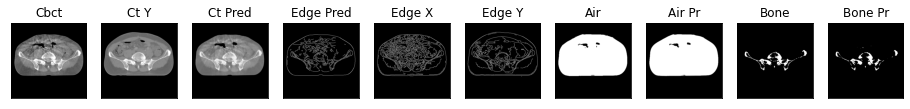

163it [01:09,  2.18it/s]

ssim score = 0.8126365542411804
psnr score = 21.359912872314453
snr score = 12.254678726196289
mae error = 0.030460262671113014
air dice score = 0.9970198253330808
bone dice score = 0.9203539823019065
contour dice score = 0.3570229411125183
edge dice score = 0.4585512578487396


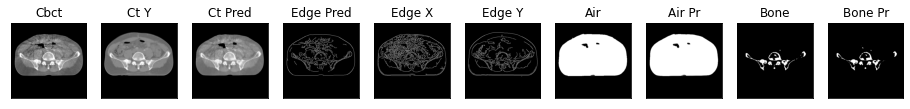

164it [01:09,  2.28it/s]

ssim score = 0.8688983917236328
psnr score = 24.969083786010742
snr score = 15.349996566772461
mae error = 0.024121446534991264
air dice score = 0.9966889126507159
bone dice score = 0.9008695652198542
contour dice score = 0.5564711689949036
edge dice score = 0.49106526374816895


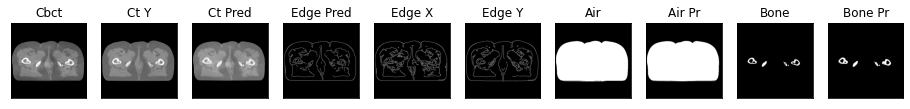

165it [01:10,  2.35it/s]

ssim score = 0.8698933124542236
psnr score = 25.32301139831543
snr score = 15.824935913085938
mae error = 0.022483862936496735
air dice score = 0.9970704555441651
bone dice score = 0.9063622912723238
contour dice score = 0.5625308752059937
edge dice score = 0.48952436447143555


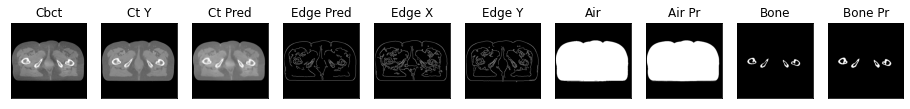

166it [01:10,  2.43it/s]

ssim score = 0.8664014339447021
psnr score = 25.41194725036621
snr score = 15.99678897857666
mae error = 0.021853135898709297
air dice score = 0.997329413562506
bone dice score = 0.9095754806794294
contour dice score = 0.5458984375
edge dice score = 0.4871225953102112


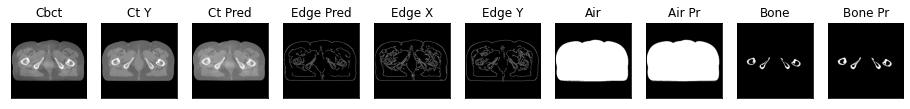

167it [01:10,  2.47it/s]

ssim score = 0.8643218278884888
psnr score = 25.437644958496094
snr score = 16.085933685302734
mae error = 0.02175125665962696
air dice score = 0.9974215603905341
bone dice score = 0.9217063560061383
contour dice score = 0.5680819749832153
edge dice score = 0.4923167824745178


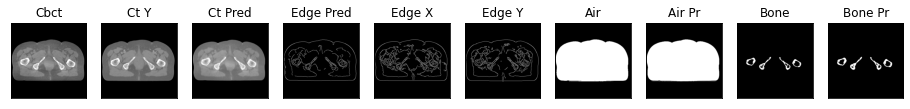

168it [01:11,  2.49it/s]

ssim score = 0.8643301725387573
psnr score = 25.30780029296875
snr score = 15.984548568725586
mae error = 0.021948324516415596
air dice score = 0.9975979745082357
bone dice score = 0.9349309369290243
contour dice score = 0.5538612604141235
edge dice score = 0.46896013617515564


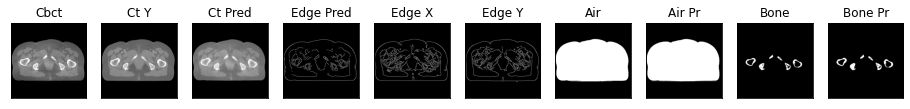

169it [01:11,  2.50it/s]

ssim score = 0.8664028644561768
psnr score = 25.250232696533203
snr score = 15.949934959411621
mae error = 0.021715059876441956
air dice score = 0.9972654394726636
bone dice score = 0.9330333967826089
contour dice score = 0.552093505859375
edge dice score = 0.47871389985084534


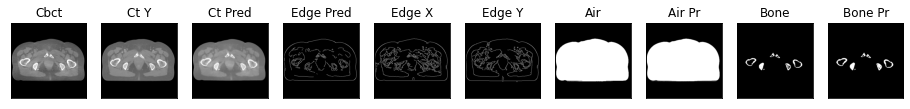

170it [01:12,  2.53it/s]

ssim score = 0.8633723855018616
psnr score = 25.195114135742188
snr score = 15.926143646240234
mae error = 0.021719178184866905
air dice score = 0.9971932091454024
bone dice score = 0.9310168625458862
contour dice score = 0.5362318754196167
edge dice score = 0.4998553693294525


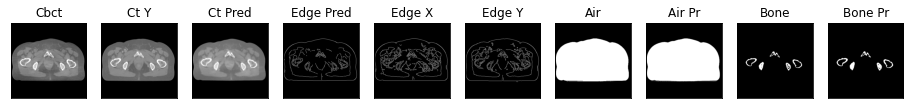

171it [01:12,  2.53it/s]

ssim score = 0.8625582456588745
psnr score = 25.147605895996094
snr score = 15.92699909210205
mae error = 0.021778741851449013
air dice score = 0.9972982463684007
bone dice score = 0.9354135212223551
contour dice score = 0.5467355847358704
edge dice score = 0.5000468492507935


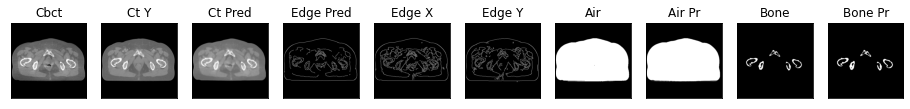

172it [01:12,  2.53it/s]

ssim score = 0.8627761006355286
psnr score = 24.757787704467773
snr score = 15.579924583435059
mae error = 0.021879201754927635
air dice score = 0.9973469856020211
bone dice score = 0.935366047325149
contour dice score = 0.5561959743499756
edge dice score = 0.49639299511909485


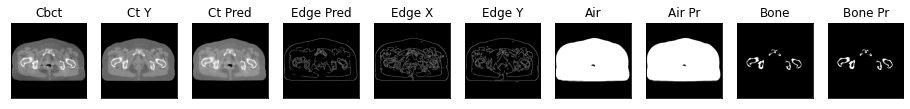

173it [01:13,  2.20it/s]

ssim score = 0.8612108826637268
psnr score = 24.72149085998535
snr score = 15.631330490112305
mae error = 0.021669860929250717
air dice score = 0.9973551610198059
bone dice score = 0.9356150932818682
contour dice score = 0.558878481388092
edge dice score = 0.4971855878829956


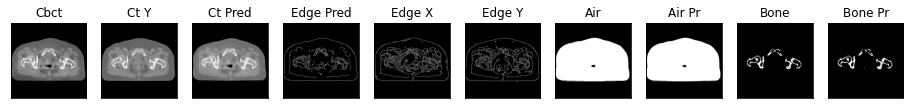

174it [01:13,  2.27it/s]

ssim score = 0.8647572994232178
psnr score = 25.770706176757812
snr score = 16.793819427490234
mae error = 0.0200805701315403
air dice score = 0.996960789909254
bone dice score = 0.9365442504522992
contour dice score = 0.5202952027320862
edge dice score = 0.47367972135543823


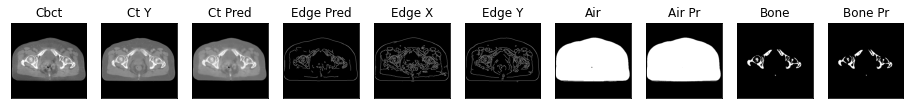

175it [01:14,  2.34it/s]

ssim score = 0.8661160469055176
psnr score = 24.958324432373047
snr score = 15.852882385253906
mae error = 0.021089907735586166
air dice score = 0.9972491944069354
bone dice score = 0.9160794362601524
contour dice score = 0.5256351232528687
edge dice score = 0.49181970953941345


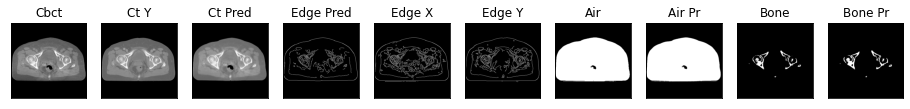

176it [01:14,  2.39it/s]

ssim score = 0.8669804930686951
psnr score = 24.92821502685547
snr score = 15.713353157043457
mae error = 0.02146693505346775
air dice score = 0.9969925349144573
bone dice score = 0.8904085569017989
contour dice score = 0.5037383437156677
edge dice score = 0.4865463078022003


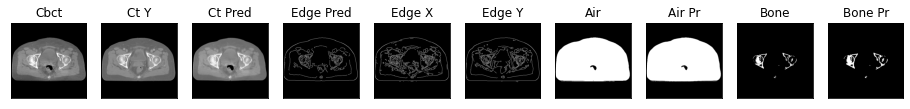

177it [01:15,  2.43it/s]

ssim score = 0.8687330484390259
psnr score = 24.927997589111328
snr score = 15.686010360717773
mae error = 0.021873606368899345
air dice score = 0.9968308229177817
bone dice score = 0.9254688251334273
contour dice score = 0.5132905840873718
edge dice score = 0.4915376305580139


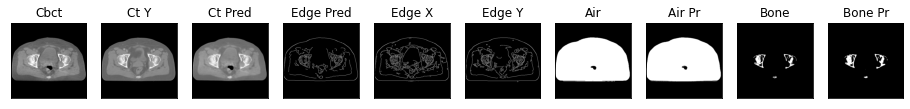

178it [01:15,  2.46it/s]

ssim score = 0.8727248311042786
psnr score = 25.516511917114258
snr score = 16.26651954650879
mae error = 0.02169371396303177
air dice score = 0.9972806701558866
bone dice score = 0.9309751134773677
contour dice score = 0.49859943985939026
edge dice score = 0.46985915303230286


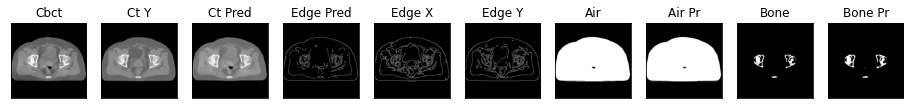

179it [01:15,  2.50it/s]

ssim score = 0.8734217286109924
psnr score = 26.18303680419922
snr score = 16.967273712158203
mae error = 0.020503241568803787
air dice score = 0.9973040914788303
bone dice score = 0.9389728096685955
contour dice score = 0.5169491767883301
edge dice score = 0.45224133133888245


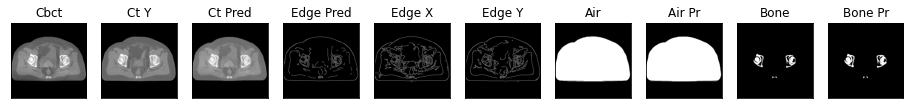

180it [01:16,  2.51it/s]

ssim score = 0.8692240715026855
psnr score = 25.629924774169922
snr score = 16.465652465820312
mae error = 0.021693209186196327
air dice score = 0.9977125932518041
bone dice score = 0.9568965517248015
contour dice score = 0.5483405590057373
edge dice score = 0.4333333373069763


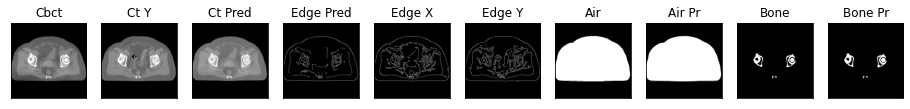

181it [01:16,  2.52it/s]

ssim score = 0.8574976921081543
psnr score = 24.732288360595703
snr score = 15.605575561523438
mae error = 0.0236807931214571
air dice score = 0.9976347274419904
bone dice score = 0.9447550147986722
contour dice score = 0.5712904930114746
edge dice score = 0.4241519868373871


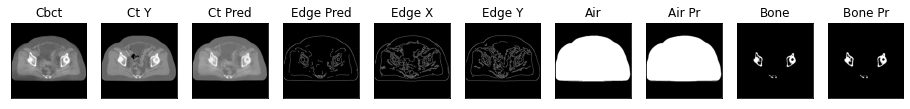

182it [01:17,  2.20it/s]

ssim score = 0.840318500995636
psnr score = 23.197967529296875
snr score = 13.998817443847656
mae error = 0.027373360469937325
air dice score = 0.9973392066868696
bone dice score = 0.908645003067471
contour dice score = 0.5637518167495728
edge dice score = 0.45271995663642883


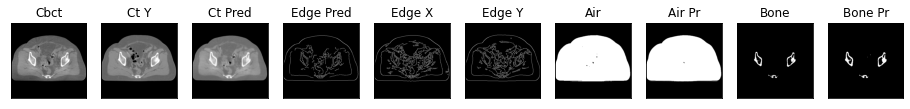

183it [01:17,  2.28it/s]

ssim score = 0.8298485279083252
psnr score = 22.678754806518555
snr score = 13.461610794067383
mae error = 0.029438413679599762
air dice score = 0.9977883483385407
bone dice score = 0.9225659123952135
contour dice score = 0.5316205620765686
edge dice score = 0.42513686418533325


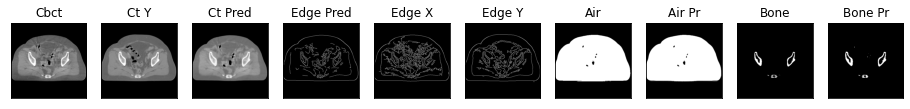

184it [01:17,  2.36it/s]

ssim score = 0.8279188871383667
psnr score = 23.341867446899414
snr score = 14.189640045166016
mae error = 0.0284831915050745
air dice score = 0.9977788247963938
bone dice score = 0.9333602584827674
contour dice score = 0.5286561250686646
edge dice score = 0.4252215623855591


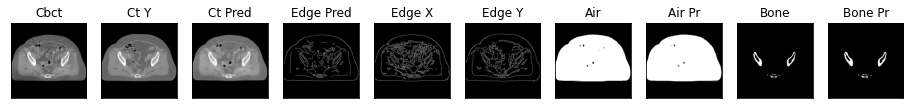

185it [01:18,  2.42it/s]

ssim score = 0.8298996686935425
psnr score = 23.617122650146484
snr score = 14.519987106323242
mae error = 0.027702558785676956
air dice score = 0.9978454457525946
bone dice score = 0.9376957883756057
contour dice score = 0.5505226254463196
edge dice score = 0.4568037986755371


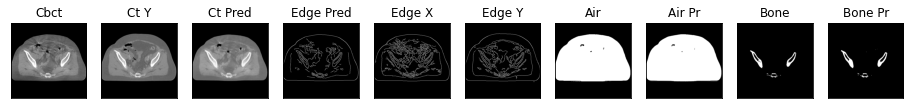

186it [01:18,  2.48it/s]

ssim score = 0.8270119428634644
psnr score = 23.12175941467285
snr score = 14.089055061340332
mae error = 0.02843307889997959
air dice score = 0.9977073161062711
bone dice score = 0.9459179137658036
contour dice score = 0.5336609482765198
edge dice score = 0.409926176071167


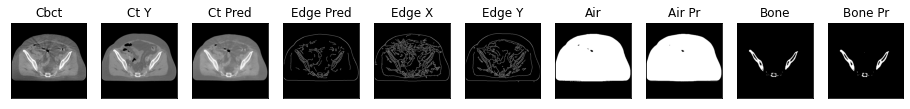

187it [01:19,  2.54it/s]

ssim score = 0.8250955939292908
psnr score = 23.01149559020996
snr score = 14.05164909362793
mae error = 0.028593765571713448
air dice score = 0.997850702453346
bone dice score = 0.9379571931734224
contour dice score = 0.5155248641967773
edge dice score = 0.43487635254859924


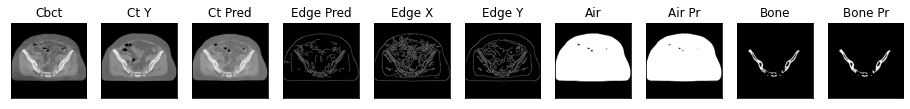

188it [01:19,  2.56it/s]

ssim score = 0.8266052007675171
psnr score = 23.015769958496094
snr score = 14.051636695861816
mae error = 0.028746599331498146
air dice score = 0.9978356244515955
bone dice score = 0.921600877194057
contour dice score = 0.5126953125
edge dice score = 0.4322447180747986


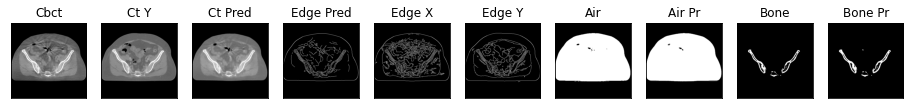

189it [01:19,  2.57it/s]

ssim score = 0.8279479742050171
psnr score = 23.015993118286133
snr score = 14.029679298400879
mae error = 0.028880123049020767
air dice score = 0.998055201370376
bone dice score = 0.9191825972324432
contour dice score = 0.5143134593963623
edge dice score = 0.4481339454650879


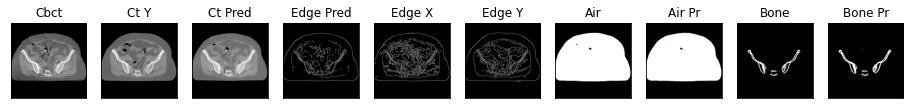

190it [01:20,  2.58it/s]

ssim score = 0.834619402885437
psnr score = 23.714664459228516
snr score = 14.739985466003418
mae error = 0.027536774054169655
air dice score = 0.9979378547304859
bone dice score = 0.9177275838478066
contour dice score = 0.5525554418563843
edge dice score = 0.48334068059921265


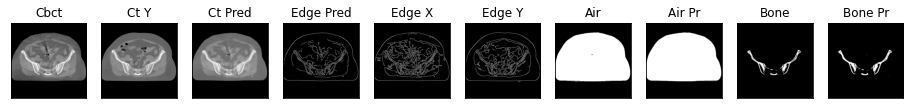

191it [01:20,  2.37it/s]


In [39]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [40]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(discriminator)

In [41]:
discriminator.load_state_dict(checkpoint["dicriminator"])

<All keys matched successfully>

In [42]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_mask_test, score_acc_test 
# unmasked
eval_epoch(model, discriminator, testloader, device)

191it [00:15, 12.27it/s]


(0.4237804918389046,
 0.8483263091891223,
 23.660690457408965,
 14.664962444005836,
 0.02659860578077938,
 0.9980286466844661,
 0.9217788264465561,
 0.5235556523213212,
 0.5)

In [43]:
# import torchvision.models as models
# models.vgg16(pretrained=True)